Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# Brain tumor 3D segmentation with MONAI

This tutorial shows how to construct a training workflow of multi-labels segmentation task.

And it contains below features:
1. Transforms for dictionary format data.
1. Define a new transform according to MONAI transform API.
1. Load Nifti image with metadata, load a list of images and stack them.
1. Randomly adjust intensity for data augmentation.
1. Cache IO and transforms to accelerate training and validation.
1. 3D SegResNet model, Dice loss function, Mean Dice metric for 3D segmentation task.
1. Deterministic training for reproducibility.

The dataset comes from http://medicaldecathlon.com/.  
Target: Gliomas segmentation necrotic/active tumour and oedema  
Modality: Multimodal multisite MRI data (FLAIR, T1w, T1gd,T2w)  
Size: 750 4D volumes (484 Training + 266 Testing)  
Source: BRATS 2016 and 2017 datasets.  
Challenge: Complex and heterogeneously-located targets

Below figure shows image patches with the tumor sub-regions that are annotated in the different modalities (top left) and the final labels for the whole dataset (right).
(Figure taken from the [BraTS IEEE TMI paper](https://ieeexplore.ieee.org/document/6975210/))

![image](../figures/brats_tasks.png)

The image patches show from left to right:
1. the whole tumor (yellow) visible in T2-FLAIR (Fig.A).
1. the tumor core (red) visible in T2 (Fig.B).
1. the enhancing tumor structures (light blue) visible in T1Gd, surrounding the cystic/necrotic components of the core (green) (Fig. C).
1. The segmentations are combined to generate the final labels of the tumor sub-regions (Fig.D): edema (yellow), non-enhancing solid core (red), necrotic/cystic core (green), enhancing core (blue).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/3d_segmentation/brats_segmentation_3d.ipynb)

In [1]:
pip install monai

Note: you may need to restart the kernel to use updated packages.


In [2]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

2024-05-01 12:15:58.291140: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 12:15:58.291313: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 12:15:58.293122: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
pip install einops

Note: you may need to restart the kernel to use updated packages.


In [4]:
!pip install thop

## Setup imports

In [5]:

from __future__ import annotations

import os
import shutil
import sys
import warnings
from collections.abc import Callable, Sequence
from pathlib import Path
from typing import Any

import numpy as np

from monai.apps.tcia import (
    download_tcia_series_instance,
    get_tcia_metadata,
    get_tcia_ref_uid,
    match_tcia_ref_uid_in_study,
)
# from monai.apps.utils import download_and_extract
from monai.config.type_definitions import PathLike
from monai.data import (
    CacheDataset,
    PydicomReader,
    load_decathlon_datalist,
    load_decathlon_properties,
    partition_dataset,
    select_cross_validation_folds,
)
from monai.transforms import LoadImaged, Randomizable
from monai.utils import ensure_tuple

def _basename(p: PathLike) -> str:
    """get the last part of the path (removing the trailing slash if it exists)"""
    sep = os.path.sep + (os.path.altsep or "") + "/ "
    return Path(f"{p}".rstrip(sep)).name

def extractall(
    filepath: PathLike,
    output_dir: PathLike = ".",
    hash_val: str | None = None,
    hash_type: str = "md5",
    file_type: str = "",
    has_base: bool = True,
) -> None:
    """
    Extract file to the output directory.
    Expected file types are: `zip`, `tar.gz` and `tar`.

    Args:
        filepath: the file path of compressed file.
        output_dir: target directory to save extracted files.
        hash_val: expected hash value to validate the compressed file.
            if None, skip hash validation.
        hash_type: 'md5' or 'sha1', defaults to 'md5'.
        file_type: string of file type for decompressing. Leave it empty to infer the type from the filepath basename.
        has_base: whether the extracted files have a base folder. This flag is used when checking if the existing
            folder is a result of `extractall`, if it is, the extraction is skipped. For example, if A.zip is unzipped
            to folder structure `A/*.png`, this flag should be True; if B.zip is unzipped to `*.png`, this flag should
            be False.

    Raises:
        RuntimeError: When the hash validation of the ``filepath`` compressed file fails.
        NotImplementedError: When the ``filepath`` file extension is not one of [zip", "tar.gz", "tar"].

    """
    if has_base:
        # the extracted files will be in this folder
        cache_dir = Path(output_dir, _basename(filepath).split(".")[0])
    else:
        cache_dir = Path(output_dir)
    if cache_dir.exists() and next(cache_dir.iterdir(), None) is not None:
        logger.info(f"Non-empty folder exists in {cache_dir}, skipped extracting.")
        return
    filepath = Path(filepath)
    if hash_val and not check_hash(filepath, hash_val, hash_type):
        raise RuntimeError(
            f"{hash_type} check of compressed file failed: " f"filepath={filepath}, expected {hash_type}={hash_val}."
        )
    print(f"Writing into directory: {output_dir}.")
    _file_type = file_type.lower().strip()
    print(filepath, _file_type)
    if filepath.name.endswith("zip") or _file_type == "zip":
        zip_file = zipfile.ZipFile(filepath)
        zip_file.extractall(output_dir)
        zip_file.close()
        return
    if filepath.name.endswith("tar") or filepath.name.endswith("tar.gz") or "tar" in _file_type:
        tar_file = tarfile.open(filepath)
        tar_file.extractall(output_dir)
        tar_file.close()
        return
    raise NotImplementedError(
        f'Unsupported file type, available options are: ["zip", "tar.gz", "tar"]. name={filepath} type={file_type}.'
    )


def download_and_extract(
    url: str,
    filepath: PathLike = "",
    output_dir: PathLike = ".",
    hash_val: str | None = None,
    hash_type: str = "md5",
    file_type: str = "",
    has_base: bool = True,
    progress: bool = True,
) -> None:
    """
    Download file from URL and extract it to the output directory.

    Args:
        url: source URL link to download file.
        filepath: the file path of the downloaded compressed file.
            use this option to keep the directly downloaded compressed file, to avoid further repeated downloads.
        output_dir: target directory to save extracted files.
            default is the current directory.
        hash_val: expected hash value to validate the downloaded file.
            if None, skip hash validation.
        hash_type: 'md5' or 'sha1', defaults to 'md5'.
        file_type: string of file type for decompressing. Leave it empty to infer the type from url's base file name.
        has_base: whether the extracted files have a base folder. This flag is used when checking if the existing
            folder is a result of `extractall`, if it is, the extraction is skipped. For example, if A.zip is unzipped
            to folder structure `A/*.png`, this flag should be True; if B.zip is unzipped to `*.png`, this flag should
            be False.
        progress: whether to display progress bar.
    """
    print()
    with tempfile.TemporaryDirectory() as tmp_dir:
        filename = filepath or Path(tmp_dir, _basename(url)).resolve()
#         shutil.copy("/kaggle/input/segresnet-data/BraTS-MEN-Train.zip", tmp_dir)
#         download_url(url=url, filepath=filename, hash_val=hash_val, hash_type=hash_type, progress=progress)
        extractall(filepath=filename, output_dir=output_dir, file_type=file_type, has_base=has_base)
        
class DecathlonDataset(Randomizable, CacheDataset):
    """
    The Dataset to automatically download the data of Medical Segmentation Decathlon challenge
    (http://medicaldecathlon.com/) and generate items for training, validation or test.
    It will also load these properties from the JSON config file of dataset. user can call `get_properties()`
    to get specified properties or all the properties loaded.
    It's based on :py:class:`monai.data.CacheDataset` to accelerate the training process.

    Args:
        root_dir: user's local directory for caching and loading the MSD datasets.
        task: which task to download and execute: one of list ("Task01_BrainTumour", "Task02_Heart",
            "Task03_Liver", "Task04_Hippocampus", "Task05_Prostate", "Task06_Lung", "Task07_Pancreas",
            "Task08_HepaticVessel", "Task09_Spleen", "Task10_Colon").
        section: expected data section, can be: `training`, `validation` or `test`.
        transform: transforms to execute operations on input data.
            for further usage, use `EnsureChannelFirstd` to convert the shape to [C, H, W, D].
        download: whether to download and extract the Decathlon from resource link, default is False.
            if expected file already exists, skip downloading even set it to True.
            user can manually copy tar file or dataset folder to the root directory.
        val_frac: percentage of validation fraction in the whole dataset, default is 0.2.
        seed: random seed to randomly shuffle the datalist before splitting into training and validation, default is 0.
            note to set same seed for `training` and `validation` sections.
        cache_num: number of items to be cached. Default is `sys.maxsize`.
            will take the minimum of (cache_num, data_length x cache_rate, data_length).
        cache_rate: percentage of cached data in total, default is 1.0 (cache all).
            will take the minimum of (cache_num, data_length x cache_rate, data_length).
        num_workers: the number of worker threads if computing cache in the initialization.
            If num_workers is None then the number returned by os.cpu_count() is used.
            If a value less than 1 is specified, 1 will be used instead.
        progress: whether to display a progress bar when downloading dataset and computing the transform cache content.
        copy_cache: whether to `deepcopy` the cache content before applying the random transforms,
            default to `True`. if the random transforms don't modify the cached content
            (for example, randomly crop from the cached image and deepcopy the crop region)
            or if every cache item is only used once in a `multi-processing` environment,
            may set `copy=False` for better performance.
        as_contiguous: whether to convert the cached NumPy array or PyTorch tensor to be contiguous.
            it may help improve the performance of following logic.
        runtime_cache: whether to compute cache at the runtime, default to `False` to prepare
            the cache content at initialization. See: :py:class:`monai.data.CacheDataset`.

    Raises:
        ValueError: When ``root_dir`` is not a directory.
        ValueError: When ``task`` is not one of ["Task01_BrainTumour", "Task02_Heart",
            "Task03_Liver", "Task04_Hippocampus", "Task05_Prostate", "Task06_Lung", "Task07_Pancreas",
            "Task08_HepaticVessel", "Task09_Spleen", "Task10_Colon"].
        RuntimeError: When ``dataset_dir`` doesn't exist and downloading is not selected (``download=False``).

    Example::

        transform = Compose(
            [
                LoadImaged(keys=["image", "label"]),
                EnsureChannelFirstd(keys=["image", "label"]),
                ScaleIntensityd(keys="image"),
                ToTensord(keys=["image", "label"]),
            ]
        )

        val_data = DecathlonDataset(
            root_dir="./", task="Task09_Spleen", transform=transform, section="validation", seed=12345, download=True
        )

        print(val_data[0]["image"], val_data[0]["label"])

    """

    resource = {
        "Task01_BrainTumour": "/kaggle/input/segresnet-data/BraTS-MEN-Train",
        "Task02_Heart": "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task02_Heart.tar",
        "Task03_Liver": "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task03_Liver.tar",
        "Task04_Hippocampus": "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task04_Hippocampus.tar",
        "Task05_Prostate": "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task05_Prostate.tar",
        "Task06_Lung": "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task06_Lung.tar",
        "Task07_Pancreas": "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task07_Pancreas.tar",
        "Task08_HepaticVessel": "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task08_HepaticVessel.tar",
        "Task09_Spleen": "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar",
        "Task10_Colon": "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task10_Colon.tar",
    }
    md5 = {
        "Task01_BrainTumour": "240a19d752f0d9e9101544901065d872",
        "Task02_Heart": "06ee59366e1e5124267b774dbd654057",
        "Task03_Liver": "a90ec6c4aa7f6a3d087205e23d4e6397",
        "Task04_Hippocampus": "9d24dba78a72977dbd1d2e110310f31b",
        "Task05_Prostate": "35138f08b1efaef89d7424d2bcc928db",
        "Task06_Lung": "8afd997733c7fc0432f71255ba4e52dc",
        "Task07_Pancreas": "4f7080cfca169fa8066d17ce6eb061e4",
        "Task08_HepaticVessel": "641d79e80ec66453921d997fbf12a29c",
        "Task09_Spleen": "410d4a301da4e5b2f6f86ec3ddba524e",
        "Task10_Colon": "bad7a188931dc2f6acf72b08eb6202d0",
    }

    def __init__(
        self,
        root_dir: PathLike,
        task: str,
        section: str,
        transform: Sequence[Callable] | Callable = (),
        download: bool = False,
        seed: int = 0,
        val_frac: float = 0.2,
        cache_num: int = sys.maxsize,
        cache_rate: float = 1.0,
        num_workers: int = 1,
        progress: bool = True,
        copy_cache: bool = True,
        as_contiguous: bool = True,
        runtime_cache: bool = False,
    ) -> None:
        root_dir = Path(root_dir)
        if not root_dir.is_dir():
            raise ValueError("Root directory root_dir must be a directory.")
        self.section = section
        self.val_frac = val_frac
        self.set_random_state(seed=seed)
        if task not in self.resource:
            raise ValueError(f"Unsupported task: {task}, available options are: {list(self.resource.keys())}.")
        dataset_dir = root_dir / task
#         tarfile_name = f"{dataset_dir}.tar"
#         if download:
#             download_and_extract(
#                 url=self.resource[task],
#                 filepath=tarfile_name,
#                 output_dir=root_dir,
#                 hash_val=self.md5[task],
#                 hash_type="md5",
#                 progress=progress,
#             )

#         if not dataset_dir.exists():
#             raise RuntimeError(
#                 f"Cannot find dataset directory: {dataset_dir}, please use download=True to download it."
#             )
#         dataset_dir = "/kaggle/input/meningits-part1/brain-men-train1"
        self.indices: np.ndarray = np.array([])
        data = self._generate_data_list("/kaggle/input/segres-json")
        # as `release` key has typo in Task04 config file, ignore it.
        property_keys = [
            "name",
            "description",
            "reference",
            "licence",
            "tensorImageSize",
            "modality",
            "labels",
            "numTraining",
            "numTest",
        ]
#         self._properties = load_decathlon_properties("/kaggle/input/segres-json/dataset.json", property_keys)
        if transform == ():
            transform = LoadImaged(["image", "label"])
        CacheDataset.__init__(
            self,
            data=data,
            transform=transform,
            cache_num=cache_num,
            cache_rate=cache_rate,
            num_workers=num_workers,
            progress=progress,
            copy_cache=copy_cache,
            as_contiguous=as_contiguous,
            runtime_cache=runtime_cache,
        )


# [docs]
    def get_indices(self) -> np.ndarray:
        """
        Get the indices of datalist used in this dataset.

        """
        return self.indices




# [docs]
    def randomize(self, data: np.ndarray) -> None:
        self.R.shuffle(data)




# [docs]
    def get_properties(self, keys: Sequence[str] | str | None = None) -> dict:
        """
        Get the loaded properties of dataset with specified keys.
        If no keys specified, return all the loaded properties.

        """
        if keys is None:
            return self._properties
        if self._properties is not None:
            return {key: self._properties[key] for key in ensure_tuple(keys)}
        return {}



    def _generate_data_list(self, dataset_dir: PathLike) -> list[dict]:
        # the types of the item in data list should be compatible with the dataloader
        dataset_dir = Path(dataset_dir) 
        section = "training" if self.section in ["training", "validation", "test"] else "test"
        datalist = load_decathlon_datalist("/kaggle/input/segres-json/dataset.json", True, section)
#         datalist2 = load_decathlon_datalist("/kaggle/input/segres-json/dataset.json", True, section)
#         datalist = datalist.append(datalist2)
#         print(datalist[898])
#         print(".............................................................................")
        return self._split_datalist(datalist)

    def _split_datalist(self, datalist: list[dict]) -> list[dict]:
#         if self.section == "test":
#             return datalist
        length = len(datalist)
        indices = np.arange(length)
        self.randomize(indices)

        
        val_length = int(length * self.val_frac)
        
        if self.section == "training":
            self.indices = indices[val_length:]
        elif self.section == "validation":
            self.indices = indices[:100]
        else:
            self.indices = indices[100:200]
#         print(self.indices)
        return [datalist[i] for i in self.indices]

2024-05-01 12:16:58.229004: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 12:16:58.229059: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 12:16:58.230545: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
import os
import shutil
import tempfile
import time
import matplotlib.pyplot as plt
# from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, decollate_batch
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
# from monai.networks.nets import SegResNet
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
)
from monai.utils import set_determinism

import torch

print_config()

MONAI version: 1.3.0
Numpy version: 1.26.4
Pytorch version: 2.1.2
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /opt/conda/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.5.0.post2
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.22.0
scipy version: 1.11.4
Pillow version: 9.5.0
Tensorboard version: 2.15.1
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.16.2
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.3
pandas version: 2.2.2
einops version: 0.8.0
transformers version: 4.39.3
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/i

## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [7]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpgy1ilnmc


## Set deterministic training for reproducibility

In [8]:
set_determinism(seed=0)

## Define a new transform to convert brain tumor labels

Here we convert the multi-classes labels into multi-labels segmentation task in One-Hot format.

In [9]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is the peritumoral edema
    label 2 is the GD-enhancing tumor
    label 3 is the necrotic and non-enhancing tumor core
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # merge label 2 and label 3 to construct TC
            result.append(torch.logical_or(d[key] == 2, d[key] == 3))
            # merge labels 1, 2 and 3 to construct WT
            result.append(torch.logical_or(torch.logical_or(d[key] == 2, d[key] == 3), d[key] == 1))
            # label 2 is ET
            result.append(d[key] == 2)
            d[key] = torch.stack(result, axis=0).float()
        return d

## Setup transforms for training and validation

In [10]:
train_transform = Compose(
    [
        # load 4 Nifti images and stack them together
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        RandSpatialCropd(keys=["image", "label"], roi_size=[128, 128, 128], random_size=False),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
    ]
)
val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

## Quickly load data with DecathlonDataset

Here we use `DecathlonDataset` to automatically download and extract the dataset.
It inherits MONAI `CacheDataset`, if you want to use less memory, you can set `cache_num=N` to cache N items for training and use the default args to cache all the items for validation, it depends on your memory size.

In [11]:
# here we don't cache any data in case out of memory issue
# from torch.utils.data import Subset

train_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=train_transform,
    section="training",
    download=True,
    cache_rate=0.0,
    num_workers=4,
)
# train_ds_subset = Subset(train_ds, range(10))
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4)
val_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_transform,
    section="validation",
    download=False,
    cache_rate=0.0,
    num_workers=4,
)

# val_ds_subset = Subset(train_ds, range(10))
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4)

test_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_transform,
    section="test",
    download=False,
    cache_rate=0.0,
    num_workers=4,
)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=4)

print(len(train_ds), len(val_ds), len(test_ds))

800 100 100


## Check data shape and visualize

image shape: torch.Size([4, 240, 240, 155])


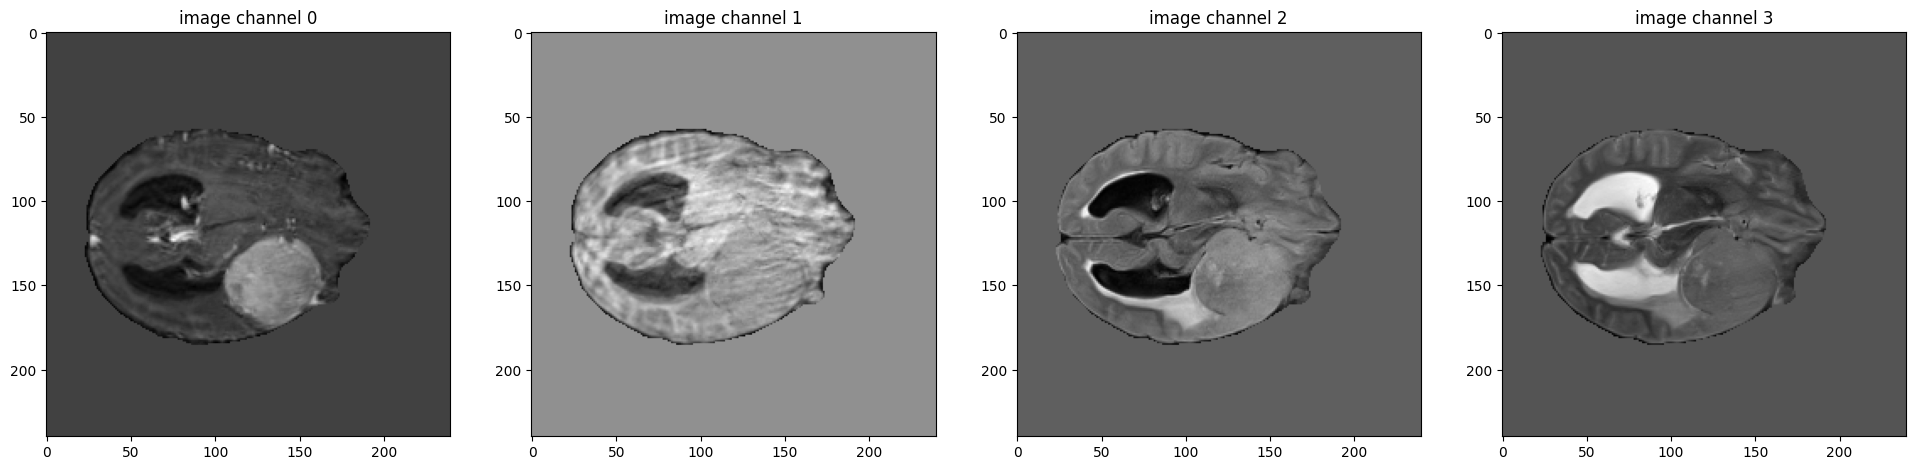

label shape: torch.Size([3, 240, 240, 155])


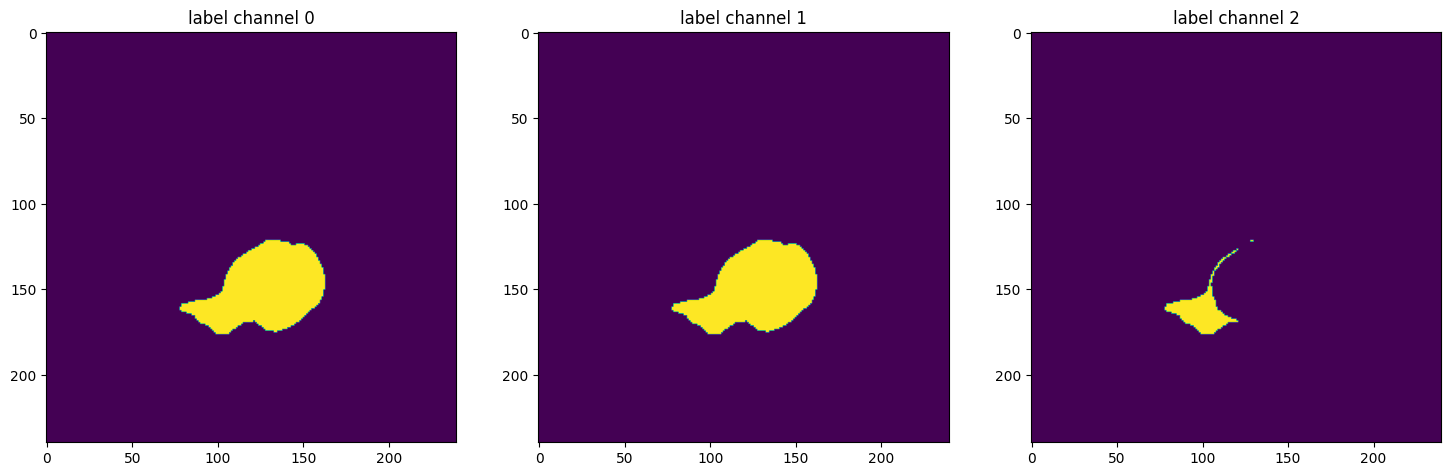

In [12]:
# pick one image from DecathlonDataset to visualize and check the 4 channels
val_data_example = val_ds[2]
print(f"image shape: {val_data_example['image'].shape}")
plt.figure("image", (24, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(val_data_example["image"][i, :, :, 60].detach().cpu(), cmap="gray")
plt.show()
# also visualize the 3 channels label corresponding to this image
print(f"label shape: {val_data_example['label'].shape}")
plt.figure("label", (18, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(val_data_example["label"][i, :, :, 60].detach().cpu())
plt.show()

## Create Model, Loss, Optimizer

## Execute a typical PyTorch training process

In [13]:
# Copyright (c) MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from __future__ import annotations

import itertools
from collections.abc import Sequence

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as checkpoint
from torch.nn import LayerNorm
from typing_extensions import Final

from monai.networks.blocks import MLPBlock as Mlp
from monai.networks.blocks import PatchEmbed, UnetOutBlock, UnetrBasicBlock, UnetrUpBlock
from monai.networks.layers import DropPath, trunc_normal_
from monai.utils import ensure_tuple_rep, look_up_option, optional_import
from monai.utils.deprecate_utils import deprecated_arg
from monai.networks.layers.factories import Act, Conv, Norm, Pool, split_args
from monai.networks.blocks import Convolution

class ChannelSELayer(nn.Module):
    """
    Re-implementation of the Squeeze-and-Excitation block based on:
    "Hu et al., Squeeze-and-Excitation Networks, https://arxiv.org/abs/1709.01507".
    """

    def __init__(
        self,
        spatial_dims: int,
        in_channels: int,
        r: int = 2,
        acti_type_1: tuple[str, dict] | str = ("relu", {"inplace": True}),
        acti_type_2: tuple[str, dict] | str = "sigmoid",
        add_residual: bool = False,
    ) -> None:
        """
        Args:
            spatial_dims: number of spatial dimensions, could be 1, 2, or 3.
            in_channels: number of input channels.
            r: the reduction ratio r in the paper. Defaults to 2.
            acti_type_1: activation type of the hidden squeeze layer. Defaults to ``("relu", {"inplace": True})``.
            acti_type_2: activation type of the output squeeze layer. Defaults to "sigmoid".

        Raises:
            ValueError: When ``r`` is nonpositive or larger than ``in_channels``.

        See also:

            :py:class:`monai.networks.layers.Act`

        """
        super().__init__()

        self.add_residual = add_residual

        pool_type = Pool[Pool.ADAPTIVEAVG, spatial_dims]
        self.avg_pool = pool_type(1)  # spatial size (1, 1, ...)

        channels = int(in_channels // r)
        if channels <= 0:
            raise ValueError(f"r must be positive and smaller than in_channels, got r={r} in_channels={in_channels}.")

        act_1, act_1_args = split_args(acti_type_1)
        act_2, act_2_args = split_args(acti_type_2)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, channels, bias=True),
            Act[act_1](**act_1_args),
            nn.Linear(channels, in_channels, bias=True),
            Act[act_2](**act_2_args),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: in shape (batch, in_channels, spatial_1[, spatial_2, ...]).
        """
        b, c = x.shape[:2]
        y: torch.Tensor = self.avg_pool(x).view(b, c)
        y = self.fc(y).view([b, c] + [1] * (x.ndim - 2))
        result = x * y

        # Residual connection is moved here instead of providing an override of forward in ResidualSELayer since
        # Torchscript has an issue with using super().
        if self.add_residual:
            result += x

        return result


class SEBlock(nn.Module):
    """
    Residual module enhanced with Squeeze-and-Excitation::

        ----+- conv1 --  conv2 -- conv3 -- SE -o---
            |                                  |
            +---(channel project if needed)----+

    Re-implementation of the SE-Resnet block based on:
    "Hu et al., Squeeze-and-Excitation Networks, https://arxiv.org/abs/1709.01507".
    """

    def __init__(
        self,
        spatial_dims: int,
        in_channels: int,
        n_chns_1: int,
        n_chns_2: int,
        n_chns_3: int,
        conv_param_1: dict | None = None,
        conv_param_2: dict | None = None,
        conv_param_3: dict | None = None,
        project: Convolution | None = None,
        r: int = 2,
        acti_type_1: tuple[str, dict] | str = ("relu", {"inplace": True}),
        acti_type_2: tuple[str, dict] | str = "sigmoid",
        acti_type_final: tuple[str, dict] | str | None = ("relu", {"inplace": True}),
    ):
        """
        Args:
            spatial_dims: number of spatial dimensions, could be 1, 2, or 3.
            in_channels: number of input channels.
            n_chns_1: number of output channels in the 1st convolution.
            n_chns_2: number of output channels in the 2nd convolution.
            n_chns_3: number of output channels in the 3rd convolution.
            conv_param_1: additional parameters to the 1st convolution.
                Defaults to ``{"kernel_size": 1, "norm": Norm.BATCH, "act": ("relu", {"inplace": True})}``
            conv_param_2: additional parameters to the 2nd convolution.
                Defaults to ``{"kernel_size": 3, "norm": Norm.BATCH, "act": ("relu", {"inplace": True})}``
            conv_param_3: additional parameters to the 3rd convolution.
                Defaults to ``{"kernel_size": 1, "norm": Norm.BATCH, "act": None}``
            project: in the case of residual chns and output chns doesn't match, a project
                (Conv) layer/block is used to adjust the number of chns. In SENET, it is
                consisted with a Conv layer as well as a Norm layer.
                Defaults to None (chns are matchable) or a Conv layer with kernel size 1.
            r: the reduction ratio r in the paper. Defaults to 2.
            acti_type_1: activation type of the hidden squeeze layer. Defaults to "relu".
            acti_type_2: activation type of the output squeeze layer. Defaults to "sigmoid".
            acti_type_final: activation type of the end of the block. Defaults to "relu".

        See also:

            :py:class:`monai.networks.blocks.ChannelSELayer`

        """
        super().__init__()

        if not conv_param_1:
            conv_param_1 = {"kernel_size": 1, "norm": Norm.BATCH, "act": ("relu", {"inplace": True})}
        self.conv1 = Convolution(
            spatial_dims=spatial_dims, in_channels=in_channels, out_channels=n_chns_1, **conv_param_1
        )

        if not conv_param_2:
            conv_param_2 = {"kernel_size": 3, "norm": Norm.BATCH, "act": ("relu", {"inplace": True})}
        self.conv2 = Convolution(spatial_dims=spatial_dims, in_channels=n_chns_1, out_channels=n_chns_2, **conv_param_2)

        if not conv_param_3:
            conv_param_3 = {"kernel_size": 1, "norm": Norm.BATCH, "act": None}
        self.conv3 = Convolution(spatial_dims=spatial_dims, in_channels=n_chns_2, out_channels=n_chns_3, **conv_param_3)

        self.se_layer = ChannelSELayer(
            spatial_dims=spatial_dims, in_channels=n_chns_3, r=r, acti_type_1=acti_type_1, acti_type_2=acti_type_2
        )

        if project is None and in_channels != n_chns_3:
            self.project = Conv[Conv.CONV, spatial_dims](in_channels, n_chns_3, kernel_size=1)
        elif project is None:
            self.project = nn.Identity()
        else:
            self.project = project

        if acti_type_final is not None:
            act_final, act_final_args = split_args(acti_type_final)
            self.act = Act[act_final](**act_final_args)
        else:
            self.act = nn.Identity()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: in shape (batch, in_channels, spatial_1[, spatial_2, ...]).
        """
        residual = self.project(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.se_layer(x)
        x += residual
        x = self.act(x)
        return x


rearrange, _ = optional_import("einops", name="rearrange")

__all__ = [
    "SwinUNETR",
    "window_partition",
    "window_reverse",
    "WindowAttention",
    "SwinTransformerBlock",
    "PatchMerging",
    "PatchMergingV2",
    "MERGING_MODE",
    "BasicLayer",
    "SwinTransformer",
]


class SwinUNETR(nn.Module):
    """
    Swin UNETR based on: "Hatamizadeh et al.,
    Swin UNETR: Swin Transformers for Semantic Segmentation of Brain Tumors in MRI Images
    <https://arxiv.org/abs/2201.01266>"
    """

    patch_size: Final[int] = 2

    @deprecated_arg(
        name="img_size",
        since="1.3",
        removed="1.5",
        msg_suffix="The img_size argument is not required anymore and "
        "checks on the input size are run during forward().",
    )
    def __init__(
        self,
        img_size: Sequence[int] | int,
        in_channels: int,
        out_channels: int,
        depths: Sequence[int] = (2, 2, 2, 2),
        num_heads: Sequence[int] = (3, 6, 12, 24),
        feature_size: int = 24,
        norm_name: tuple | str = "instance",
        drop_rate: float = 0.0,
        attn_drop_rate: float = 0.0,
        dropout_path_rate: float = 0.0,
        normalize: bool = True,
        use_checkpoint: bool = False,
        spatial_dims: int = 3,
        downsample="merging",
        use_v2=False,
    ) -> None:
        """
        Args:
            img_size: spatial dimension of input image.
                This argument is only used for checking that the input image size is divisible by the patch size.
                The tensor passed to forward() can have a dynamic shape as long as its spatial dimensions are divisible by 2**5.
                It will be removed in an upcoming version.
            in_channels: dimension of input channels.
            out_channels: dimension of output channels.
            feature_size: dimension of network feature size.
            depths: number of layers in each stage.
            num_heads: number of attention heads.
            norm_name: feature normalization type and arguments.
            drop_rate: dropout rate.
            attn_drop_rate: attention dropout rate.
            dropout_path_rate: drop path rate.
            normalize: normalize output intermediate features in each stage.
            use_checkpoint: use gradient checkpointing for reduced memory usage.
            spatial_dims: number of spatial dims.
            downsample: module used for downsampling, available options are `"mergingv2"`, `"merging"` and a
                user-specified `nn.Module` following the API defined in :py:class:`monai.networks.nets.PatchMerging`.
                The default is currently `"merging"` (the original version defined in v0.9.0).
            use_v2: using swinunetr_v2, which adds a residual convolution block at the beggining of each swin stage.

        Examples::

            # for 3D single channel input with size (96,96,96), 4-channel output and feature size of 48.
            >>> net = SwinUNETR(img_size=(96,96,96), in_channels=1, out_channels=4, feature_size=48)

            # for 3D 4-channel input with size (128,128,128), 3-channel output and (2,4,2,2) layers in each stage.
            >>> net = SwinUNETR(img_size=(128,128,128), in_channels=4, out_channels=3, depths=(2,4,2,2))

            # for 2D single channel input with size (96,96), 2-channel output and gradient checkpointing.
            >>> net = SwinUNETR(img_size=(96,96), in_channels=3, out_channels=2, use_checkpoint=True, spatial_dims=2)

        """

        super().__init__()

        img_size = ensure_tuple_rep(img_size, spatial_dims)
        patch_sizes = ensure_tuple_rep(self.patch_size, spatial_dims)
        window_size = ensure_tuple_rep(7, spatial_dims)

        if spatial_dims not in (2, 3):
            raise ValueError("spatial dimension should be 2 or 3.")

        self._check_input_size(img_size)

        if not (0 <= drop_rate <= 1):
            raise ValueError("dropout rate should be between 0 and 1.")

        if not (0 <= attn_drop_rate <= 1):
            raise ValueError("attention dropout rate should be between 0 and 1.")

        if not (0 <= dropout_path_rate <= 1):
            raise ValueError("drop path rate should be between 0 and 1.")

        if feature_size % 12 != 0:
            raise ValueError("feature_size should be divisible by 12.")

        self.normalize = normalize
       

        self.swinViT = SwinTransformer(
            in_chans=in_channels,
            embed_dim=feature_size,
            window_size=window_size,
            patch_size=patch_sizes,
            depths=depths,
            num_heads=num_heads,
            mlp_ratio=4.0,
            qkv_bias=True,
            drop_rate=drop_rate,
            attn_drop_rate=attn_drop_rate,
            drop_path_rate=dropout_path_rate,
            norm_layer=nn.LayerNorm,
            use_checkpoint=use_checkpoint,
            spatial_dims=spatial_dims,
            downsample=look_up_option(downsample, MERGING_MODE) if isinstance(downsample, str) else downsample,
            use_v2=use_v2,
        )

        self.encoder1 = SEBlock(
            spatial_dims=spatial_dims,
            in_channels=in_channels,
            n_chns_1=feature_size,
            n_chns_2=feature_size,
            n_chns_3=feature_size,
            conv_param_1={"kernel_size": 3, "norm": Norm.BATCH, "act": ("relu", {"inplace": True})},
            conv_param_2={"kernel_size": 3, "norm": Norm.BATCH, "act": ("relu", {"inplace": True})},
            conv_param_3={"kernel_size": 3, "norm": Norm.BATCH, "act": None},
            project=None,
            r=2,
            acti_type_1=("relu", {"inplace": True}),
            acti_type_2="sigmoid",
            acti_type_final=("relu", {"inplace": True}),
        )

        self.encoder2 = SEBlock(
            spatial_dims=spatial_dims,
            in_channels=feature_size,
            n_chns_1=feature_size,
            n_chns_2=feature_size,
            n_chns_3=feature_size,
            conv_param_1={"kernel_size": 3, "norm": Norm.BATCH, "act": ("relu", {"inplace": True})},
            conv_param_2={"kernel_size": 3, "norm": Norm.BATCH, "act": ("relu", {"inplace": True})},
            conv_param_3={"kernel_size": 3, "norm": Norm.BATCH, "act": None},
            project=None,
            r=2,
            acti_type_1=("relu", {"inplace": True}),
            acti_type_2="sigmoid",
            acti_type_final=("relu", {"inplace": True}),
        )

        self.encoder3 = SEBlock(
            spatial_dims=spatial_dims,
            in_channels=2 * feature_size,
            n_chns_1=2 * feature_size,
            n_chns_2=2 * feature_size,
            n_chns_3=2 * feature_size,
            conv_param_1={"kernel_size": 3, "norm": Norm.BATCH, "act": ("relu", {"inplace": True})},
            conv_param_2={"kernel_size": 3, "norm": Norm.BATCH, "act": ("relu", {"inplace": True})},
            conv_param_3={"kernel_size": 3, "norm": Norm.BATCH, "act": None},
            project=None,
            r=2,
            acti_type_1=("relu", {"inplace": True}),
            acti_type_2="sigmoid",
            acti_type_final=("relu", {"inplace": True}),
        )

        self.encoder4 = SEBlock(
            spatial_dims=spatial_dims,
            in_channels=4 * feature_size,
            n_chns_1=4 * feature_size,
            n_chns_2=4 * feature_size,
            n_chns_3=4 * feature_size,
            conv_param_1={"kernel_size": 3, "norm": Norm.BATCH, "act": ("relu", {"inplace": True})},
            conv_param_2={"kernel_size": 3, "norm": Norm.BATCH, "act": ("relu", {"inplace": True})},
            conv_param_3={"kernel_size": 3, "norm": Norm.BATCH, "act": None},
            project=None,
            r=2,
            acti_type_1=("relu", {"inplace": True}),
            acti_type_2="sigmoid",
            acti_type_final=("relu", {"inplace": True}),
        )

        self.encoder10 = SEBlock(
            spatial_dims=spatial_dims,
            in_channels=16 * feature_size,
            n_chns_1=16 * feature_size,
            n_chns_2=16 * feature_size,
            n_chns_3=16 * feature_size,
            conv_param_1={"kernel_size": 3, "norm": Norm.BATCH, "act": ("relu", {"inplace": True})},
            conv_param_2={"kernel_size": 3, "norm": Norm.BATCH, "act": ("relu", {"inplace": True})},
            conv_param_3={"kernel_size": 3, "norm": Norm.BATCH, "act": None},
            project=None,
            r=2,
            acti_type_1=("relu", {"inplace": True}),
            acti_type_2="sigmoid",
            acti_type_final=("relu", {"inplace": True}),
        )


        self.decoder5 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=16 * feature_size,
            out_channels=8 * feature_size,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=True,
        )

        self.decoder4 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=feature_size * 8,
            out_channels=feature_size * 4,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=True,
        )

        self.decoder3 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=feature_size * 4,
            out_channels=feature_size * 2,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=True,
        )
        self.decoder2 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=feature_size * 2,
            out_channels=feature_size,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=True,
        )

        self.decoder1 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=feature_size,
            out_channels=feature_size,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=True,
        )

        self.out = UnetOutBlock(spatial_dims=spatial_dims, in_channels=feature_size, out_channels=out_channels)

    def load_from(self, weights):
        with torch.no_grad():
            self.swinViT.patch_embed.proj.weight.copy_(weights["state_dict"]["module.patch_embed.proj.weight"])
            self.swinViT.patch_embed.proj.bias.copy_(weights["state_dict"]["module.patch_embed.proj.bias"])
            for bname, block in self.swinViT.layers1[0].blocks.named_children():
                block.load_from(weights, n_block=bname, layer="layers1")
            self.swinViT.layers1[0].downsample.reduction.weight.copy_(
                weights["state_dict"]["module.layers1.0.downsample.reduction.weight"]
            )
            self.swinViT.layers1[0].downsample.norm.weight.copy_(
                weights["state_dict"]["module.layers1.0.downsample.norm.weight"]
            )
            self.swinViT.layers1[0].downsample.norm.bias.copy_(
                weights["state_dict"]["module.layers1.0.downsample.norm.bias"]
            )
            for bname, block in self.swinViT.layers2[0].blocks.named_children():
                block.load_from(weights, n_block=bname, layer="layers2")
            self.swinViT.layers2[0].downsample.reduction.weight.copy_(
                weights["state_dict"]["module.layers2.0.downsample.reduction.weight"]
            )
            self.swinViT.layers2[0].downsample.norm.weight.copy_(
                weights["state_dict"]["module.layers2.0.downsample.norm.weight"]
            )
            self.swinViT.layers2[0].downsample.norm.bias.copy_(
                weights["state_dict"]["module.layers2.0.downsample.norm.bias"]
            )
            for bname, block in self.swinViT.layers3[0].blocks.named_children():
                block.load_from(weights, n_block=bname, layer="layers3")
            self.swinViT.layers3[0].downsample.reduction.weight.copy_(
                weights["state_dict"]["module.layers3.0.downsample.reduction.weight"]
            )
            self.swinViT.layers3[0].downsample.norm.weight.copy_(
                weights["state_dict"]["module.layers3.0.downsample.norm.weight"]
            )
            self.swinViT.layers3[0].downsample.norm.bias.copy_(
                weights["state_dict"]["module.layers3.0.downsample.norm.bias"]
            )
            for bname, block in self.swinViT.layers4[0].blocks.named_children():
                block.load_from(weights, n_block=bname, layer="layers4")
            self.swinViT.layers4[0].downsample.reduction.weight.copy_(
                weights["state_dict"]["module.layers4.0.downsample.reduction.weight"]
            )
            self.swinViT.layers4[0].downsample.norm.weight.copy_(
                weights["state_dict"]["module.layers4.0.downsample.norm.weight"]
            )
            self.swinViT.layers4[0].downsample.norm.bias.copy_(
                weights["state_dict"]["module.layers4.0.downsample.norm.bias"]
            )

    @torch.jit.unused
    def _check_input_size(self, spatial_shape):
        img_size = np.array(spatial_shape)
        remainder = (img_size % np.power(self.patch_size, 5)) > 0
        if remainder.any():
            wrong_dims = (np.where(remainder)[0] + 2).tolist()
            raise ValueError(
                f"spatial dimensions {wrong_dims} of input image (spatial shape: {spatial_shape})"
                f" must be divisible by {self.patch_size}**5."
            )

    def forward(self, x_in):
        if not torch.jit.is_scripting():
            self._check_input_size(x_in.shape[2:])
        
        hidden_states_out = self.swinViT(x_in, self.normalize)
        enc0 = self.encoder1(x_in)
        enc1 = hidden_states_out[0]
        enc2 = hidden_states_out[1]
        enc3 = hidden_states_out[2]
        dec4 = hidden_states_out[4]
        dec3 = self.decoder5(dec4, hidden_states_out[3])
        dec2 = self.decoder4(dec3, enc3)
        dec1 = self.decoder3(dec2, enc2)
        dec0 = self.decoder2(dec1, enc1)
        out = self.decoder1(dec0, enc0)
        logits = self.out(out)
        return logits


def window_partition(x, window_size):
    """window partition operation based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer

     Args:
        x: input tensor.
        window_size: local window size.
    """
    x_shape = x.size()
    if len(x_shape) == 5:
        b, d, h, w, c = x_shape
        x = x.view(
            b,
            d // window_size[0],
            window_size[0],
            h // window_size[1],
            window_size[1],
            w // window_size[2],
            window_size[2],
            c,
        )
        windows = (
            x.permute(0, 1, 3, 5, 2, 4, 6, 7).contiguous().view(-1, window_size[0] * window_size[1] * window_size[2], c)
        )
    elif len(x_shape) == 4:
        b, h, w, c = x.shape
        x = x.view(b, h // window_size[0], window_size[0], w // window_size[1], window_size[1], c)
        windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size[0] * window_size[1], c)
    return windows


def window_reverse(windows, window_size, dims):
    """window reverse operation based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer

     Args:
        windows: windows tensor.
        window_size: local window size.
        dims: dimension values.
    """
    if len(dims) == 4:
        b, d, h, w = dims
        x = windows.view(
            b,
            d // window_size[0],
            h // window_size[1],
            w // window_size[2],
            window_size[0],
            window_size[1],
            window_size[2],
            -1,
        )
        x = x.permute(0, 1, 4, 2, 5, 3, 6, 7).contiguous().view(b, d, h, w, -1)

    elif len(dims) == 3:
        b, h, w = dims
        x = windows.view(b, h // window_size[0], w // window_size[1], window_size[0], window_size[1], -1)
        x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(b, h, w, -1)
    return x


def get_window_size(x_size, window_size, shift_size=None):
    """Computing window size based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer

     Args:
        x_size: input size.
        window_size: local window size.
        shift_size: window shifting size.
    """

    use_window_size = list(window_size)
    if shift_size is not None:
        use_shift_size = list(shift_size)
    for i in range(len(x_size)):
        if x_size[i] <= window_size[i]:
            use_window_size[i] = x_size[i]
            if shift_size is not None:
                use_shift_size[i] = 0

    if shift_size is None:
        return tuple(use_window_size)
    else:
        return tuple(use_window_size), tuple(use_shift_size)


class WindowAttention(nn.Module):
    """
    Window based multi-head self attention module with relative position bias based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer
    """

    def __init__(
        self,
        dim: int,
        num_heads: int,
        window_size: Sequence[int],
        qkv_bias: bool = False,
        attn_drop: float = 0.0,
        proj_drop: float = 0.0,
    ) -> None:
        """
        Args:
            dim: number of feature channels.
            num_heads: number of attention heads.
            window_size: local window size.
            qkv_bias: add a learnable bias to query, key, value.
            attn_drop: attention dropout rate.
            proj_drop: dropout rate of output.
        """

        super().__init__()
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim**-0.5
        mesh_args = torch.meshgrid.__kwdefaults__

        if len(self.window_size) == 3:
            self.relative_position_bias_table = nn.Parameter(
                torch.zeros(
                    (2 * self.window_size[0] - 1) * (2 * self.window_size[1] - 1) * (2 * self.window_size[2] - 1),
                    num_heads,
                )
            )
            coords_d = torch.arange(self.window_size[0])
            coords_h = torch.arange(self.window_size[1])
            coords_w = torch.arange(self.window_size[2])
            if mesh_args is not None:
                coords = torch.stack(torch.meshgrid(coords_d, coords_h, coords_w, indexing="ij"))
            else:
                coords = torch.stack(torch.meshgrid(coords_d, coords_h, coords_w))
            coords_flatten = torch.flatten(coords, 1)
            relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
            relative_coords = relative_coords.permute(1, 2, 0).contiguous()
            relative_coords[:, :, 0] += self.window_size[0] - 1
            relative_coords[:, :, 1] += self.window_size[1] - 1
            relative_coords[:, :, 2] += self.window_size[2] - 1
            relative_coords[:, :, 0] *= (2 * self.window_size[1] - 1) * (2 * self.window_size[2] - 1)
            relative_coords[:, :, 1] *= 2 * self.window_size[2] - 1
        elif len(self.window_size) == 2:
            self.relative_position_bias_table = nn.Parameter(
                torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads)
            )
            coords_h = torch.arange(self.window_size[0])
            coords_w = torch.arange(self.window_size[1])
            if mesh_args is not None:
                coords = torch.stack(torch.meshgrid(coords_h, coords_w, indexing="ij"))
            else:
                coords = torch.stack(torch.meshgrid(coords_h, coords_w))
            coords_flatten = torch.flatten(coords, 1)
            relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
            relative_coords = relative_coords.permute(1, 2, 0).contiguous()
            relative_coords[:, :, 0] += self.window_size[0] - 1
            relative_coords[:, :, 1] += self.window_size[1] - 1
            relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1

        relative_position_index = relative_coords.sum(-1)
        self.register_buffer("relative_position_index", relative_position_index)
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        trunc_normal_(self.relative_position_bias_table, std=0.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask):
        b, n, c = x.shape
       
        qkv = self.qkv(x).reshape(b, n, 3, self.num_heads, c // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        q = q * self.scale
    
        attn = q @ k.transpose(-2, -1)
        
        relative_position_bias = self.relative_position_bias_table[
            self.relative_position_index.clone()[:n, :n].reshape(-1)
        ].reshape(n, n, -1)
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()
        attn = attn + relative_position_bias.unsqueeze(0)
        
        if mask is not None:
            nw = mask.shape[0]
            attn = attn.view(b // nw, nw, self.num_heads, n, n) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, n, n)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn).to(v.dtype)
        x = (attn @ v).transpose(1, 2).reshape(b, n, c)
        x = self.proj(x)
        
        x = self.proj_drop(x)
        return x


class SwinTransformerBlock(nn.Module):
    """
    Swin Transformer block based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer
    """

    def __init__(
        self,
        dim: int,
        num_heads: int,
        window_size: Sequence[int],
        shift_size: Sequence[int],
        mlp_ratio: float = 4.0,
        qkv_bias: bool = True,
        drop: float = 0.0,
        attn_drop: float = 0.0,
        drop_path: float = 0.0,
        act_layer: str = "GELU",
        norm_layer: type[LayerNorm] = nn.LayerNorm,
        use_checkpoint: bool = False,
    ) -> None:
        """
        Args:
            dim: number of feature channels.
            num_heads: number of attention heads.
            window_size: local window size.
            shift_size: window shift size.
            mlp_ratio: ratio of mlp hidden dim to embedding dim.
            qkv_bias: add a learnable bias to query, key, value.
            drop: dropout rate.
            attn_drop: attention dropout rate.
            drop_path: stochastic depth rate.
            act_layer: activation layer.
            norm_layer: normalization layer.
            use_checkpoint: use gradient checkpointing for reduced memory usage.
        """

        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        self.use_checkpoint = use_checkpoint
        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim,
            window_size=self.window_size,
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            attn_drop=attn_drop,
            proj_drop=drop,
        )

        self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(hidden_size=dim, mlp_dim=mlp_hidden_dim, act=act_layer, dropout_rate=drop, dropout_mode="swin")

    def forward_part1(self, x, mask_matrix):
        x_shape = x.size()
        x = self.norm1(x)
        if len(x_shape) == 5:
            b, d, h, w, c = x.shape
            window_size, shift_size = get_window_size((d, h, w), self.window_size, self.shift_size)
            pad_l = pad_t = pad_d0 = 0
            pad_d1 = (window_size[0] - d % window_size[0]) % window_size[0]
            pad_b = (window_size[1] - h % window_size[1]) % window_size[1]
            pad_r = (window_size[2] - w % window_size[2]) % window_size[2]
            x = F.pad(x, (0, 0, pad_l, pad_r, pad_t, pad_b, pad_d0, pad_d1))
            _, dp, hp, wp, _ = x.shape
            dims = [b, dp, hp, wp]

        elif len(x_shape) == 4:
            b, h, w, c = x.shape
            window_size, shift_size = get_window_size((h, w), self.window_size, self.shift_size)
            pad_l = pad_t = 0
            pad_b = (window_size[0] - h % window_size[0]) % window_size[0]
            pad_r = (window_size[1] - w % window_size[1]) % window_size[1]
            x = F.pad(x, (0, 0, pad_l, pad_r, pad_t, pad_b))
            _, hp, wp, _ = x.shape
            dims = [b, hp, wp]

        if any(i > 0 for i in shift_size):
            if len(x_shape) == 5:
                shifted_x = torch.roll(x, shifts=(-shift_size[0], -shift_size[1], -shift_size[2]), dims=(1, 2, 3))
            elif len(x_shape) == 4:
                shifted_x = torch.roll(x, shifts=(-shift_size[0], -shift_size[1]), dims=(1, 2))
            attn_mask = mask_matrix
        else:
            shifted_x = x
            attn_mask = None
        x_windows = window_partition(shifted_x, window_size)
        attn_windows = self.attn(x_windows, mask=attn_mask)
        attn_windows = attn_windows.view(-1, *(window_size + (c,)))
        shifted_x = window_reverse(attn_windows, window_size, dims)
        if any(i > 0 for i in shift_size):
            if len(x_shape) == 5:
                x = torch.roll(shifted_x, shifts=(shift_size[0], shift_size[1], shift_size[2]), dims=(1, 2, 3))
            elif len(x_shape) == 4:
                x = torch.roll(shifted_x, shifts=(shift_size[0], shift_size[1]), dims=(1, 2))
        else:
            x = shifted_x

        if len(x_shape) == 5:
            if pad_d1 > 0 or pad_r > 0 or pad_b > 0:
                x = x[:, :d, :h, :w, :].contiguous()
        elif len(x_shape) == 4:
            if pad_r > 0 or pad_b > 0:
                x = x[:, :h, :w, :].contiguous()

        return x

    def forward_part2(self, x):
        return self.drop_path(self.mlp(self.norm2(x)))

    def load_from(self, weights, n_block, layer):
        root = f"module.{layer}.0.blocks.{n_block}."
        block_names = [
            "norm1.weight",
            "norm1.bias",
            "attn.relative_position_bias_table",
            "attn.relative_position_index",
            "attn.qkv.weight",
            "attn.qkv.bias",
            "attn.proj.weight",
            "attn.proj.bias",
            "norm2.weight",
            "norm2.bias",
            "mlp.fc1.weight",
            "mlp.fc1.bias",
            "mlp.fc2.weight",
            "mlp.fc2.bias",
        ]
        with torch.no_grad():
            self.norm1.weight.copy_(weights["state_dict"][root + block_names[0]])
            self.norm1.bias.copy_(weights["state_dict"][root + block_names[1]])
            self.attn.relative_position_bias_table.copy_(weights["state_dict"][root + block_names[2]])
            self.attn.relative_position_index.copy_(weights["state_dict"][root + block_names[3]])
            self.attn.qkv.weight.copy_(weights["state_dict"][root + block_names[4]])
            self.attn.qkv.bias.copy_(weights["state_dict"][root + block_names[5]])
            self.attn.proj.weight.copy_(weights["state_dict"][root + block_names[6]])
            self.attn.proj.bias.copy_(weights["state_dict"][root + block_names[7]])
            self.norm2.weight.copy_(weights["state_dict"][root + block_names[8]])
            self.norm2.bias.copy_(weights["state_dict"][root + block_names[9]])
            self.mlp.linear1.weight.copy_(weights["state_dict"][root + block_names[10]])
            self.mlp.linear1.bias.copy_(weights["state_dict"][root + block_names[11]])
            self.mlp.linear2.weight.copy_(weights["state_dict"][root + block_names[12]])
            self.mlp.linear2.bias.copy_(weights["state_dict"][root + block_names[13]])

    def forward(self, x, mask_matrix):
        shortcut = x
        if self.use_checkpoint:
            x = checkpoint.checkpoint(self.forward_part1, x, mask_matrix, use_reentrant=False)
        else:
            x = self.forward_part1(x, mask_matrix)
        x = shortcut + self.drop_path(x)
        if self.use_checkpoint:
            x = x + checkpoint.checkpoint(self.forward_part2, x, use_reentrant=False)
        else:
            x = x + self.forward_part2(x)
        return x


class PatchMergingV2(nn.Module):
    """
    Patch merging layer based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer
    """

    def __init__(self, dim: int, norm_layer: type[LayerNorm] = nn.LayerNorm, spatial_dims: int = 3) -> None:
        """
        Args:
            dim: number of feature channels.
            norm_layer: normalization layer.
            spatial_dims: number of spatial dims.
        """

        super().__init__()
        self.dim = dim
        if spatial_dims == 3:
            self.reduction = nn.Linear(8 * dim, 2 * dim, bias=False)
            self.norm = norm_layer(8 * dim)
        elif spatial_dims == 2:
            self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
            self.norm = norm_layer(4 * dim)

    def forward(self, x):
        x_shape = x.size()
        if len(x_shape) == 5:
            b, d, h, w, c = x_shape
            pad_input = (h % 2 == 1) or (w % 2 == 1) or (d % 2 == 1)
            if pad_input:
                x = F.pad(x, (0, 0, 0, w % 2, 0, h % 2, 0, d % 2))
            x = torch.cat(
                [x[:, i::2, j::2, k::2, :] for i, j, k in itertools.product(range(2), range(2), range(2))], -1
            )

        elif len(x_shape) == 4:
            b, h, w, c = x_shape
            pad_input = (h % 2 == 1) or (w % 2 == 1)
            if pad_input:
                x = F.pad(x, (0, 0, 0, w % 2, 0, h % 2))
            x = torch.cat([x[:, j::2, i::2, :] for i, j in itertools.product(range(2), range(2))], -1)

        x = self.norm(x)
        x = self.reduction(x)
        return x


class PatchMerging(PatchMergingV2):
    """The `PatchMerging` module previously defined in v0.9.0."""

    def forward(self, x):
        x_shape = x.size()
        if len(x_shape) == 4:
            return super().forward(x)
        if len(x_shape) != 5:
            raise ValueError(f"expecting 5D x, got {x.shape}.")
        b, d, h, w, c = x_shape
        pad_input = (h % 2 == 1) or (w % 2 == 1) or (d % 2 == 1)
        if pad_input:
            x = F.pad(x, (0, 0, 0, w % 2, 0, h % 2, 0, d % 2))
        x0 = x[:, 0::2, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, 0::2, :]
        x3 = x[:, 0::2, 0::2, 1::2, :]
        x4 = x[:, 1::2, 0::2, 1::2, :]
        x5 = x[:, 0::2, 1::2, 0::2, :]
        x6 = x[:, 0::2, 0::2, 1::2, :]
        x7 = x[:, 1::2, 1::2, 1::2, :]
        x = torch.cat([x0, x1, x2, x3, x4, x5, x6, x7], -1)
        x = self.norm(x)
        x = self.reduction(x)
        return x


MERGING_MODE = {"merging": PatchMerging, "mergingv2": PatchMergingV2}


def compute_mask(dims, window_size, shift_size, device):
    """Computing region masks based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer

     Args:
        dims: dimension values.
        window_size: local window size.
        shift_size: shift size.
        device: device.
    """

    cnt = 0

    if len(dims) == 3:
        d, h, w = dims
        img_mask = torch.zeros((1, d, h, w, 1), device=device)
        for d in slice(-window_size[0]), slice(-window_size[0], -shift_size[0]), slice(-shift_size[0], None):
            for h in slice(-window_size[1]), slice(-window_size[1], -shift_size[1]), slice(-shift_size[1], None):
                for w in slice(-window_size[2]), slice(-window_size[2], -shift_size[2]), slice(-shift_size[2], None):
                    img_mask[:, d, h, w, :] = cnt
                    cnt += 1

    elif len(dims) == 2:
        h, w = dims
        img_mask = torch.zeros((1, h, w, 1), device=device)
        for h in slice(-window_size[0]), slice(-window_size[0], -shift_size[0]), slice(-shift_size[0], None):
            for w in slice(-window_size[1]), slice(-window_size[1], -shift_size[1]), slice(-shift_size[1], None):
                img_mask[:, h, w, :] = cnt
                cnt += 1

    mask_windows = window_partition(img_mask, window_size)
    mask_windows = mask_windows.squeeze(-1)
    attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
    attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))

    return attn_mask


class BasicLayer(nn.Module):
    """
    Basic Swin Transformer layer in one stage based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer
    """

    def __init__(
        self,
        dim: int,
        depth: int,
        num_heads: int,
        window_size: Sequence[int],
        drop_path: list,
        mlp_ratio: float = 4.0,
        qkv_bias: bool = False,
        drop: float = 0.0,
        attn_drop: float = 0.0,
        norm_layer: type[LayerNorm] = nn.LayerNorm,
        downsample: nn.Module | None = None,
        use_checkpoint: bool = False,
    ) -> None:
        """
        Args:
            dim: number of feature channels.
            depth: number of layers in each stage.
            num_heads: number of attention heads.
            window_size: local window size.
            drop_path: stochastic depth rate.
            mlp_ratio: ratio of mlp hidden dim to embedding dim.
            qkv_bias: add a learnable bias to query, key, value.
            drop: dropout rate.
            attn_drop: attention dropout rate.
            norm_layer: normalization layer.
            downsample: an optional downsampling layer at the end of the layer.
            use_checkpoint: use gradient checkpointing for reduced memory usage.
        """

        super().__init__()
        self.window_size = window_size
        self.shift_size = tuple(i // 2 for i in window_size)
        self.no_shift = tuple(0 for i in window_size)
        self.depth = depth
        self.use_checkpoint = use_checkpoint
        self.blocks = nn.ModuleList(
            [
                SwinTransformerBlock(
                    dim=dim,
                    num_heads=num_heads,
                    window_size=self.window_size,
                    shift_size=self.no_shift if (i % 2 == 0) else self.shift_size,
                    mlp_ratio=mlp_ratio,
                    qkv_bias=qkv_bias,
                    drop=drop,
                    attn_drop=attn_drop,
                    drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                    norm_layer=norm_layer,
                    use_checkpoint=use_checkpoint,
                )
                for i in range(depth)
            ]
        )
        self.downsample = downsample
        if callable(self.downsample):
            self.downsample = downsample(dim=dim, norm_layer=norm_layer, spatial_dims=len(self.window_size))

    def forward(self, x):
        x_shape = x.size()
        if len(x_shape) == 5:
            b, c, d, h, w = x_shape
            window_size, shift_size = get_window_size((d, h, w), self.window_size, self.shift_size)
            x = rearrange(x, "b c d h w -> b d h w c")
            dp = int(np.ceil(d / window_size[0])) * window_size[0]
            hp = int(np.ceil(h / window_size[1])) * window_size[1]
            wp = int(np.ceil(w / window_size[2])) * window_size[2]
            attn_mask = compute_mask([dp, hp, wp], window_size, shift_size, x.device)
            for blk in self.blocks:
                x = blk(x, attn_mask)
            x = x.view(b, d, h, w, -1)
            if self.downsample is not None:
                x = self.downsample(x)
            x = rearrange(x, "b d h w c -> b c d h w")

        elif len(x_shape) == 4:
            b, c, h, w = x_shape
            window_size, shift_size = get_window_size((h, w), self.window_size, self.shift_size)
            x = rearrange(x, "b c h w -> b h w c")
            hp = int(np.ceil(h / window_size[0])) * window_size[0]
            wp = int(np.ceil(w / window_size[1])) * window_size[1]
            attn_mask = compute_mask([hp, wp], window_size, shift_size, x.device)
            for blk in self.blocks:
                x = blk(x, attn_mask)
            x = x.view(b, h, w, -1)
            if self.downsample is not None:
                x = self.downsample(x)
            x = rearrange(x, "b h w c -> b c h w")
        return x


class SwinTransformer(nn.Module):
    """
    Swin Transformer based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer
    """

    def __init__(
        self,
        in_chans: int,
        embed_dim: int,
        window_size: Sequence[int],
        patch_size: Sequence[int],
        depths: Sequence[int],
        num_heads: Sequence[int],
        mlp_ratio: float = 4.0,
        qkv_bias: bool = True,
        drop_rate: float = 0.0,
        attn_drop_rate: float = 0.0,
        drop_path_rate: float = 0.0,
        norm_layer: type[LayerNorm] = nn.LayerNorm,
        patch_norm: bool = False,
        use_checkpoint: bool = False,
        spatial_dims: int = 3,
        downsample="merging",
        use_v2=False,
    ) -> None:
        """
        Args:
            in_chans: dimension of input channels.
            embed_dim: number of linear projection output channels.
            window_size: local window size.
            patch_size: patch size.
            depths: number of layers in each stage.
            num_heads: number of attention heads.
            mlp_ratio: ratio of mlp hidden dim to embedding dim.
            qkv_bias: add a learnable bias to query, key, value.
            drop_rate: dropout rate.
            attn_drop_rate: attention dropout rate.
            drop_path_rate: stochastic depth rate.
            norm_layer: normalization layer.
            patch_norm: add normalization after patch embedding.
            use_checkpoint: use gradient checkpointing for reduced memory usage.
            spatial_dims: spatial dimension.
            downsample: module used for downsampling, available options are `"mergingv2"`, `"merging"` and a
                user-specified `nn.Module` following the API defined in :py:class:`monai.networks.nets.PatchMerging`.
                The default is currently `"merging"` (the original version defined in v0.9.0).
            use_v2: using swinunetr_v2, which adds a residual convolution block at the beginning of each swin stage.
        """

        super().__init__()
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.patch_norm = patch_norm
        self.window_size = window_size
        self.patch_size = patch_size
        self.patch_embed = PatchEmbed(
            patch_size=self.patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None,  # type: ignore
            spatial_dims=spatial_dims,
        )
        self.pos_drop = nn.Dropout(p=drop_rate)
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]
        self.use_v2 = use_v2
        self.layers1 = nn.ModuleList()
        self.layers2 = nn.ModuleList()
        self.layers3 = nn.ModuleList()
        self.layers4 = nn.ModuleList()
        if self.use_v2:
            self.layers1c = nn.ModuleList()
            self.layers2c = nn.ModuleList()
            self.layers3c = nn.ModuleList()
            self.layers4c = nn.ModuleList()
        down_sample_mod = look_up_option(downsample, MERGING_MODE) if isinstance(downsample, str) else downsample
        for i_layer in range(self.num_layers):
            layer = BasicLayer(
                dim=int(embed_dim * 2**i_layer),
                depth=depths[i_layer],
                num_heads=num_heads[i_layer],
                window_size=self.window_size,
                drop_path=dpr[sum(depths[:i_layer]) : sum(depths[: i_layer + 1])],
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                drop=drop_rate,
                attn_drop=attn_drop_rate,
                norm_layer=norm_layer,
                downsample=down_sample_mod,
                use_checkpoint=use_checkpoint,
            )
            if i_layer == 0:
                self.layers1.append(layer)
            elif i_layer == 1:
                self.layers2.append(layer)
            elif i_layer == 2:
                self.layers3.append(layer)
            elif i_layer == 3:
                self.layers4.append(layer)
            if self.use_v2:
                layerc = UnetrBasicBlock(
                    spatial_dims=spatial_dims,
                    in_channels=embed_dim * 2**i_layer,
                    out_channels=embed_dim * 2**i_layer,
                    kernel_size=3,
                    stride=1,
                    norm_name="instance",
                    res_block=True,
                )
                if i_layer == 0:
                    self.layers1c.append(layerc)
                elif i_layer == 1:
                    self.layers2c.append(layerc)
                elif i_layer == 2:
                    self.layers3c.append(layerc)
                elif i_layer == 3:
                    self.layers4c.append(layerc)

        self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))

    def proj_out(self, x, normalize=False):
        if normalize:
            x_shape = x.size()
            if len(x_shape) == 5:
                n, ch, d, h, w = x_shape
                x = rearrange(x, "n c d h w -> n d h w c")
                x = F.layer_norm(x, [ch])
                x = rearrange(x, "n d h w c -> n c d h w")
            elif len(x_shape) == 4:
                n, ch, h, w = x_shape
                x = rearrange(x, "n c h w -> n h w c")
                x = F.layer_norm(x, [ch])
                x = rearrange(x, "n h w c -> n c h w")
        return x

    def forward(self, x, normalize=True):
        x0 = self.patch_embed(x)
        x0 = self.pos_drop(x0)
        x0_out = self.proj_out(x0, normalize)
        if self.use_v2:
            x0 = self.layers1c[0](x0.contiguous())
        x1 = self.layers1[0](x0.contiguous())
        x1_out = self.proj_out(x1, normalize)
        if self.use_v2:
            x1 = self.layers2c[0](x1.contiguous())
        x2 = self.layers2[0](x1.contiguous())
        x2_out = self.proj_out(x2, normalize)
        if self.use_v2:
            x2 = self.layers3c[0](x2.contiguous())
        x3 = self.layers3[0](x2.contiguous())
        x3_out = self.proj_out(x3, normalize)
        if self.use_v2:
            x3 = self.layers4c[0](x3.contiguous())
        x4 = self.layers4[0](x3.contiguous())
        x4_out = self.proj_out(x4, normalize)
        return [x0_out, x1_out, x2_out, x3_out, x4_out]


def filter_swinunetr(key, value):
    """
    A filter function used to filter the pretrained weights from [1], then the weights can be loaded into MONAI SwinUNETR Model.
    This function is typically used with `monai.networks.copy_model_state`
    [1] "Valanarasu JM et al., Disruptive Autoencoders: Leveraging Low-level features for 3D Medical Image Pre-training
    <https://arxiv.org/abs/2307.16896>"

    Args:
        key: the key in the source state dict used for the update.
        value: the value in the source state dict used for the update.

    Examples::

        import torch
        from monai.apps import download_url
        from monai.networks.utils import copy_model_state
        from monai.networks.nets.swin_unetr import SwinUNETR, filter_swinunetr

        model = SwinUNETR(img_size=(96, 96, 96), in_channels=1, out_channels=3, feature_size=48)
        resource = (
            "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/ssl_pretrained_weights.pth"
        )
        ssl_weights_path = "./ssl_pretrained_weights.pth"
        download_url(resource, ssl_weights_path)
        ssl_weights = torch.load(ssl_weights_path)["model"]

        dst_dict, loaded, not_loaded = copy_model_state(model, ssl_weights, filter_func=filter_swinunetr)

    """
    if key in [
        "encoder.mask_token",
        "encoder.norm.weight",
        "encoder.norm.bias",
        "out.conv.conv.weight",
        "out.conv.conv.bias",
    ]:
        return None

    if key[:8] == "encoder.":
        if key[8:19] == "patch_embed":
            new_key = "swinViT." + key[8:]
        else:
            new_key = "swinViT." + key[8:18] + key[20:]

        return new_key, value
    else:
        return None

In [14]:
max_epochs = 6
val_interval = 1
VAL_AMP = True

# standard PyTorch program style: create VNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
from monai.networks.nets import VNet
# from thop import profile
# from thop import clever_format
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.transforms import Compose, Activations, AsDiscrete
from monai.inferers import sliding_window_inference

image_size = 128

# Instantiate the model
model = SwinUNETR(img_size=(image_size, image_size, image_size), in_channels=4, out_channels=3, feature_size=48)

# Generate random inputs
# inputs = torch.rand(1, 4, image_size, image_size, image_size)

# # Perform a forward pass
# outputs = model(inputs)
# print(outputs.shape)

# # Calculate FLOPs and parameters
# flops, params = profile(model, inputs=(inputs,))
# flops, params = clever_format([flops, params], "%.2f")
# print(f"FLOPs: {flops}, Params: {params}")

# Define loss function
loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)

# Define learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

# Define Dice metric
dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

# Define post-processing transformations
post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

# Define inference method
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(128, 128, 128),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)

# Use AMP to accelerate training
scaler = torch.cuda.amp.GradScaler()

# Enable cuDNN benchmark
torch.backends.cudnn.benchmark = True


In [15]:
print(model)

SwinUNETR(
  (swinViT): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(4, 48, kernel_size=(2, 2, 2), stride=(2, 2, 2))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers1): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0-1): 2 x SwinTransformerBlock(
            (norm1): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=48, out_features=144, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=48, out_features=48, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
            (mlp): MLPBlock(
              (linear1): Linear(in_features=48, out_features=192, bias=True)
              (linear2): Linear(in_feature

In [16]:
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
val_epoch_loss_values = []
metric_values = []
train_metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []

start_epoch = 0
latest_checkpoint_path = ""
if os.path.exists(latest_checkpoint_path):
    checkpoint = torch.load(latest_checkpoint_path)
    model.load_state_dict(checkpoint)
    start_epoch = 0
    print("checkpoint loaded")
else:
    print("No checkpoint. Starting from scratch")
    
end_epoch = start_epoch + max_epochs

total_start = time.time()
model.to(device)
for epoch in range(start_epoch, end_epoch):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{end_epoch}")
    model.train()
    epoch_loss = 0
    epoch_metric = 0
    val_epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        outputs = [post_trans(i) for i in decollate_batch(outputs)]
        dice_metric(y_pred=outputs, y=labels)
        train_metric = dice_metric.aggregate().item()
        epoch_metric += train_metric
        
#         dice_metric_batch(y_pred=outputs, y=labels)
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", current mean dice: {train_metric:.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )
    lr_scheduler.step()
    epoch_loss /= step
    epoch_metric /= step
    epoch_loss_values.append(epoch_loss)
    train_metric_values.append(epoch_metric)
    print("train time: ", time.time()-epoch_start)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}"
          f", average metric: {epoch_metric:.4f}")

    if (epoch + 1) % val_interval == 0:
        val_start = time.time()
        model.eval()
        with torch.no_grad():
            val_step = 0
            for val_data in val_loader:
                val_step += 1
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = inference(val_inputs)
                loss = loss_function(val_outputs, val_labels)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)
                val_epoch_loss += loss.item()
                
            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()
            metric_tc = metric_batch[0].item()
            metric_values_tc.append(metric_tc)
            metric_wt = metric_batch[1].item()
            metric_values_wt.append(metric_wt)
            metric_et = metric_batch[2].item()
            metric_values_et.append(metric_et)
            dice_metric.reset()
            dice_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join("/kaggle/working/", f"SEBlock_best_metric_model_{epoch+1}.pth"),
                )
                print("saved new best metric model")
            chk_file_name = "unetr_epoch_" + str(epoch+1) + "_model.pth"    
            torch.save(
                    model.state_dict(),
                    os.path.join("/kaggle/working/", chk_file_name),
                )
            val_epoch_loss /= val_step
            val_epoch_loss_values.append(val_epoch_loss)
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f", val_loss: {val_epoch_loss:.4f}"
                f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
        print("val time: ", time.time()-val_start)
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start

No checkpoint. Starting from scratch
----------
epoch 1/6
1/800, train_loss: 0.9976, current mean dice: 0.0018, step time: 84.9328
2/800, train_loss: 0.9996, current mean dice: 0.0011, step time: 1.9504
3/800, train_loss: 0.8214, current mean dice: 0.0445, step time: 1.8906
4/800, train_loss: 0.9843, current mean dice: 0.0370, step time: 2.0339
5/800, train_loss: 0.9371, current mean dice: 0.0405, step time: 1.9000
6/800, train_loss: 0.9198, current mean dice: 0.0463, step time: 1.8854
7/800, train_loss: 0.9986, current mean dice: 0.0399, step time: 1.8885
8/800, train_loss: 0.6625, current mean dice: 0.0818, step time: 1.8852
9/800, train_loss: 0.9839, current mean dice: 0.0748, step time: 1.8931
10/800, train_loss: 0.9977, current mean dice: 0.0676, step time: 1.8953
11/800, train_loss: 0.8196, current mean dice: 0.0789, step time: 1.8882
12/800, train_loss: 0.8284, current mean dice: 0.0869, step time: 1.8863
13/800, train_loss: 0.9995, current mean dice: 0.0803, step time: 1.8951
1

In [17]:
print(len(val_epoch_loss_values), val_epoch_loss_values)
print(len(epoch_loss_values), epoch_loss_values)
print(len(train_metric_values), train_metric_values)
print(len(metric_values), metric_values)

6 [0.7764540834724903, 0.5158445733040571, 0.45308712001889945, 0.37630407202988864, 0.3373396715894341, 0.3289183349907398]
6 [0.7865975261572749, 0.5592414001561701, 0.4699421606794931, 0.43355202370788903, 0.4232074759085663, 0.39999722500797363]
6 [0.2850044656242244, 0.6402796816825866, 0.7039284200966358, 0.7418174187093973, 0.7402957398444414, 0.7896107822656632]
6 [0.4370802640914917, 0.6660432815551758, 0.7091739177703857, 0.7483094334602356, 0.7587839961051941, 0.7803667783737183]


In [18]:
# import shutil

# source_path = "/kaggle/input/metrics-loss/SegResNet_data.csv"
# destination_path = "/kaggle/working/UNETR_data.csv"

# # Copy the file
# shutil.copy(source_path, destination_path)

# print(f"File '{source_path}' copied to '{destination_path}'.")


In [19]:
import csv

# Your lists of data
# list1 = [1, 2, 3, 4, 5]
# list2 = ['a', 'b', 'c', 'd', 'e']
# list3 = [10, 20, 30, 40, 50]
# list4 = ['apple', 'banana', 'cherry', 'date', 'elderberry']

# CSV file path
csv_file_path = '/kaggle/working/UNETR_data.csv'

# Column names
fieldnames = ['epoch', 'epoch_loss_values', 'train_metric_values', 'val_epoch_loss_values', 'metric_values']

# Writing lists to a CSV file with specific column names
with open(csv_file_path, 'w', newline='') as csvfile:  # Change 'w' to 'a' for append mode
    # Create a CSV writer object with DictWriter
    csv_writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    csv_writer.writeheader()
    # Write the lists to the specified columns
    for i in range(len(epoch_loss_values)):
        csv_writer.writerow({
            'epoch': start_epoch + i + 1,
            'epoch_loss_values': epoch_loss_values[i],
            'train_metric_values': train_metric_values[i],
            'val_epoch_loss_values': val_epoch_loss_values[i],
            'metric_values': metric_values[i]
        })



In [20]:
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}, total time: {total_time}.")

train completed, best_metric: 0.7804 at epoch: 6, total time: 16151.852657794952.


## Plot the loss and metric

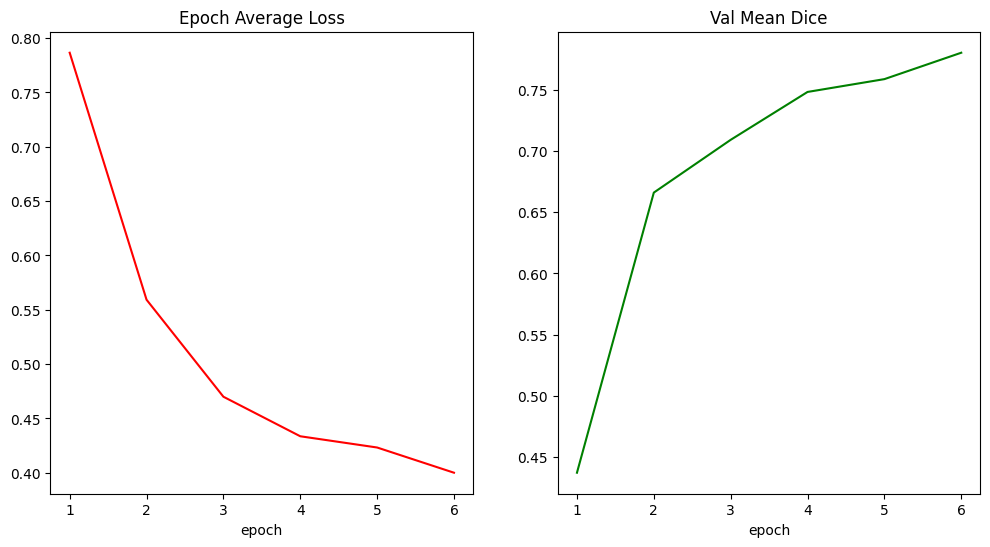

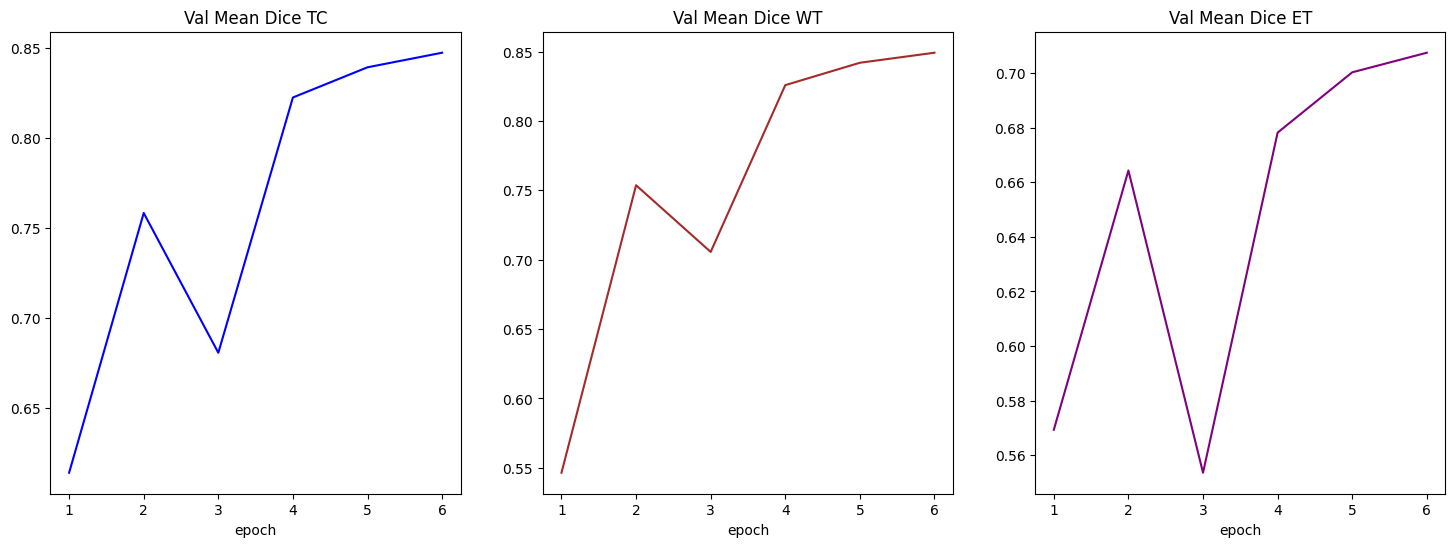

In [21]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()

plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice TC")
x = [val_interval * (i + 1) for i in range(len(metric_values_tc))]
y = metric_values_tc
plt.xlabel("epoch")
plt.plot(x, y, color="blue")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice WT")
x = [val_interval * (i + 1) for i in range(len(metric_values_wt))]
y = metric_values_wt
plt.xlabel("epoch")
plt.plot(x, y, color="brown")
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice ET")
x = [val_interval * (i + 1) for i in range(len(metric_values_et))]
y = metric_values_et
plt.xlabel("epoch")
plt.plot(x, y, color="purple")
plt.show()

## Check best model output with the input image and label

In [22]:
pip install nibabel

Note: you may need to restart the kernel to use updated packages.


In [23]:
# import nibabel as nib 
# img_add = "/kaggle/input/trainingdata-brats-part2/BraTS-GLI-00814-000/BraTS-GLI-00814-000-t1c.nii"
# label_add = "/kaggle/input/trainingdata-brats-part2/BraTS-GLI-00814-000/BraTS-GLI-00814-000-t1n.nii"
# img_add_2 = "/kaggle/input/trainingdata-brats-part2/BraTS-GLI-00814-000/BraTS-GLI-00814-000-t2f.nii"
# img_add_3 = "/kaggle/input/trainingdata-brats-part2/BraTS-GLI-00814-000/BraTS-GLI-00814-000-t2w.nii"
# img = nib.load(img_add).get_fdata()
# label = nib.load(label_add).get_fdata()
# img_2 = nib.load(img_add_2).get_fdata()
# img_3 = nib.load(img_add_3).get_fdata()
# print(f"image shape: {img.shape}, label shape: {label.shape}")
# plt.figure("image", (18, 6))
# plt.subplot(1, 4, 1)
# plt.title("BraTS-GLI-00814-000-t1c.nii")
# plt.imshow(img[:, :, 78], cmap="gray")
# plt.subplot(1, 4, 2)
# plt.title("BraTS-GLI-00814-000-t1n.nii")
# plt.imshow(label[:, :, 78], cmap="gray")
# plt.subplot(1, 4, 3)
# plt.title("BraTS-GLI-00814-000-t2f.nii")
# plt.imshow(img_2[:, :, 78], cmap="gray")
# plt.subplot(1, 4, 4)
# plt.title("BraTS-GLI-00814-000-t2w.nii")
# plt.imshow(img_3[:, :, 78], cmap="gray")
# plt.show()

In [24]:
import nibabel as nib 
from matplotlib.colors import ListedColormap
# img_add = "/kaggle/input/trainingdata-brats-part2/BraTS-GLI-00814-000/BraTS-GLI-00814-000-t2f.nii"
# label_add = "/kaggle/input/trainingdata-brats-part2/BraTS-GLI-00814-000/BraTS-GLI-00814-000-seg.nii"
# img = nib.load(img_add).get_fdata()
# label = nib.load(label_add).get_fdata()
# # Create a custom colormap with purple, blue, and orange colors
# cmap = ListedColormap(['black', 'blue', 'orange', 'green'])

# print(f"image shape: {img.shape}, label shape: {label.shape}")
# plt.figure("image", (18, 6))
# plt.subplot(1, 3, 1)
# plt.title("BraTS-GLI-00000-000-t2f.nii")
# plt.imshow(img[:, :, 78], cmap="gray")
# plt.subplot(1, 3, 2)
# plt.title("BraTS-GLI-00000-000-seg.nii")
# plt.imshow(label[:, :, 78])
# plt.subplot(1, 3, 3)
# plt.title("BraTS-GLI-00000-000-seg.nii")
# plt.imshow(label[:, :, 78], cmap = cmap)
# plt.show()

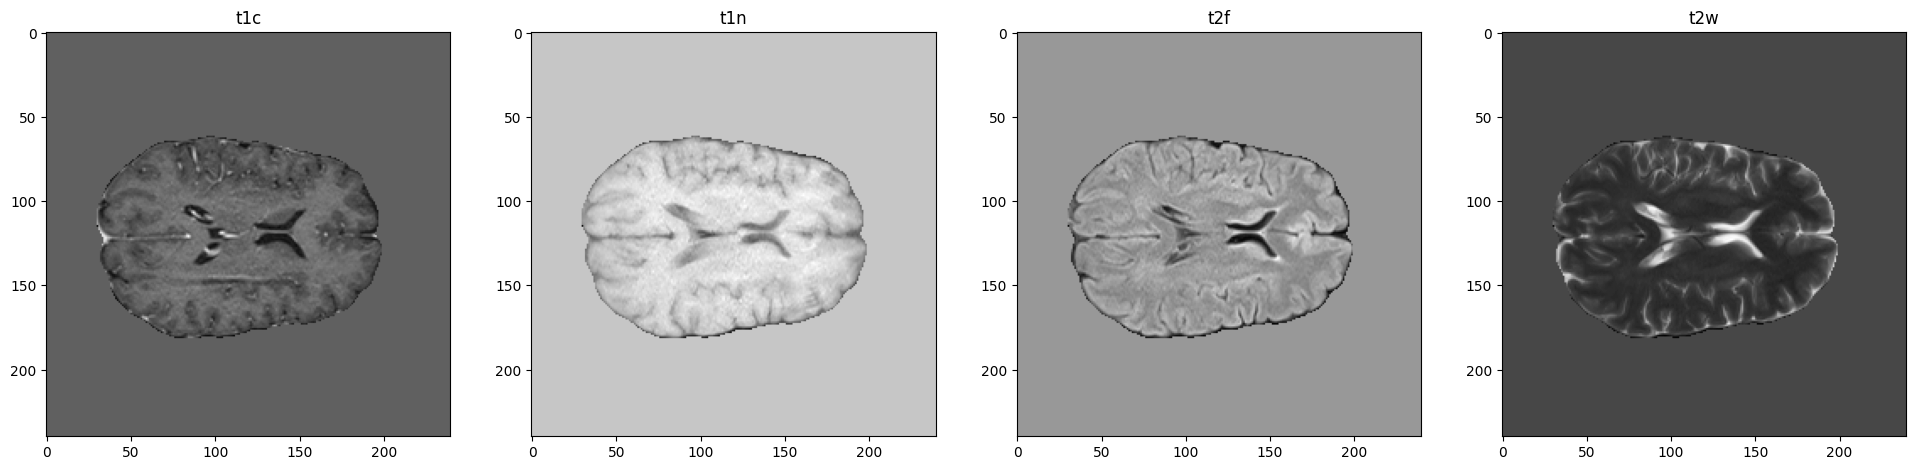

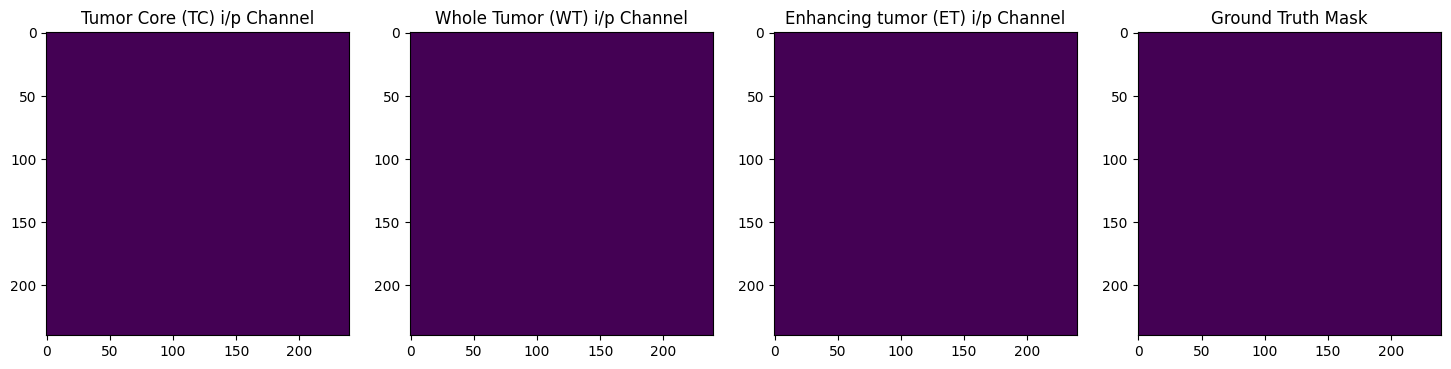

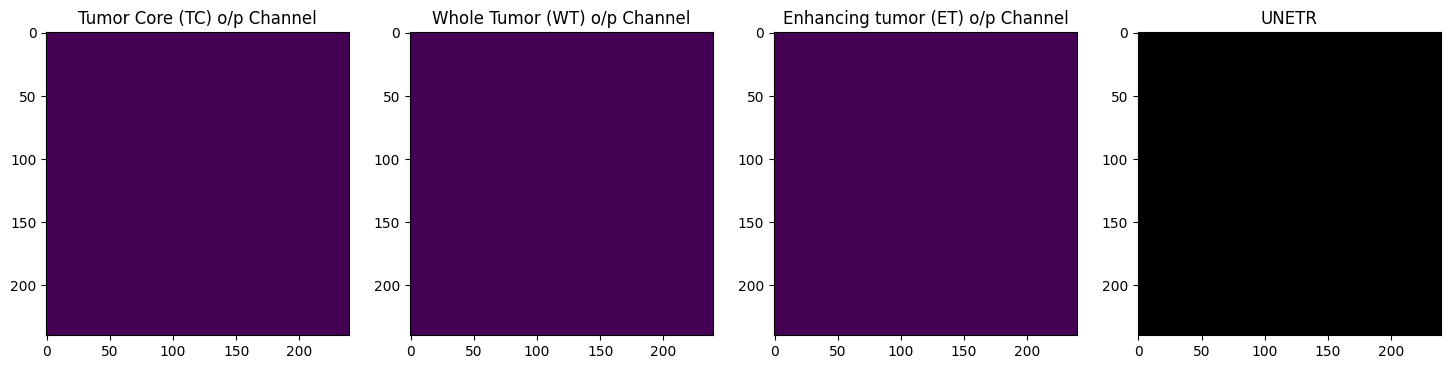

In [26]:
model.load_state_dict(torch.load("/kaggle/working/SEBlock_best_metric_model_6.pth"))
cmap = ListedColormap(['black', 'yellow', 'blue', 'red'])
model.eval()
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_input = val_ds[1]["image"].unsqueeze(0).to(device)
    roi_size = (128, 128, 128)
    sw_batch_size = 4
    val_output = inference(val_input)
    val_output = post_trans(val_output[0])
    titles_modalities = ["t1c", "t1n", "t2f", "t2w"]
    titles = ["Tumor Core (TC) i/p Channel", "Whole Tumor (WT) i/p Channel", "Enhancing tumor (ET) i/p Channel"]
    plt.figure("image", (24, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(titles_modalities[i])
        plt.imshow(val_ds[1]["image"][i, :, :, 78].detach().cpu(), cmap="gray")
    plt.show()
#     # visualize the 3 channels label corresponding to this image
#     plt.figure("label", (18, 6))
#     for i in range(3):
#         plt.subplot(1, 3, i + 1)
#         plt.title(titles[i])
#         plt.imshow(val_ds[1]["label"][i, :, :, 78].detach().cpu())
#     plt.show()
#     # visualize the 3 channels model output corresponding to this image
#     plt.figure("output", (18, 6))
#     for i in range(3):
#         plt.subplot(1, 3, i + 1)
#         plt.title(f"output channel {i}")
#         plt.imshow(val_output[i, :, :, 78].detach().cpu())
#     plt.show()
    
    seg_label = torch.zeros((val_ds[1]["label"].shape[1], val_ds[1]["label"].shape[2], val_ds[1]["label"].shape[3]))
    seg_label[val_ds[1]["label"][1] == 1] = 2
    seg_label[val_ds[1]["label"][0] == 1] = 1
    seg_label[val_ds[1]["label"][2] == 1] = 4
    
    seg_out = torch.zeros((val_output.shape[1], val_output.shape[2], val_output.shape[3]))
    seg_out[val_output[1] == 1] = 2
    seg_out[val_output[0] == 1] = 1
    seg_out[val_output[2] == 1] = 4
    
    slice_num = 78
#     img_add = "/kaggle/input/trainingdata-brats-part2/BraTS-GLI-00742-000/BraTS-GLI-00742-000-t2w.nii",
#     label_add = "/kaggle/input/trainingdata-brats-part2/BraTS-GLI-00742-000/BraTS-GLI-00742-000-seg.nii",
#     img = nib.load(img_add).get_fdata()
#     label = nib.load(label_add).get_fdata()
#     plt.figure("image", (18, 6))
# #     plt.subplot(1, 3, 1)
# #     plt.title("image")
# #     plt.imshow(seg_label[:, :, slice_num])
#     plt.subplot(1, 2, 1)
#     plt.title("Ground Truth Mask")
#     plt.imshow(seg_label[:, :, slice_num])
#     plt.subplot(1, 2, 2)
#     plt.title("Predicted Mask")
#     plt.imshow(seg_out[:, :, slice_num])
#     plt.show()
    
    plt.figure("image", (18, 6))
    for i in range(3):
        plt.subplot(1, 4, i + 1)
        plt.title(titles[i])
        plt.imshow(val_ds[1]["label"][i, :, :, 78].detach().cpu())
    plt.subplot(1, 4, 4)
    plt.title("Ground Truth Mask")
    plt.imshow(seg_label[:, :, slice_num])
    plt.show()   
    titles_output = ["Tumor Core (TC) o/p Channel", "Whole Tumor (WT) o/p Channel", "Enhancing tumor (ET) o/p Channel"]
    plt.figure("image", (18, 6))
    for i in range(3):
        plt.subplot(1, 4, i + 1)
        plt.title(titles_output[i])
        plt.imshow(val_output[i, :, :, 78].detach().cpu())
    plt.subplot(1, 4, 4)
    plt.title("UNETR")
    plt.imshow(seg_out[:, :, slice_num], cmap = cmap)
    plt.show() 

## Evaluation on original image spacings

In [27]:
val_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(1.0, 1.0, 1.0), mode="bilinear"),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=val_transform,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
            device="cpu",
        ),
        Activationsd(keys="pred", sigmoid=True),
        AsDiscreted(keys="pred", threshold=0.5),
    ]
)

In [ ]:
from monai.metrics import HausdorffDistanceMetric
from monai.metrics import SurfaceDiceMetric
from monai.metrics import MeanIoU
from monai.metrics import SurfaceDistanceMetric
from monai.metrics import ROCAUCMetric
from monai.metrics import SurfaceDiceMetric

hd_metric = HausdorffDistanceMetric(include_background=False, reduction="mean", percentile = 95)
hd_metric_batch = HausdorffDistanceMetric(include_background=True, reduction="mean_batch", percentile = 95)

sd_metric = SurfaceDistanceMetric(include_background=True, reduction="mean")
sd_metric_batch = SurfaceDistanceMetric(include_background=True, reduction="mean_batch")

meanIoU_metric = MeanIoU(include_background=True, reduction="mean")
meanIoU_metric_batch = MeanIoU(include_background=True, reduction="mean_batch")

surfaceDice_metric = SurfaceDiceMetric(include_background=True, reduction="mean", class_thresholds = (0.01, 0.01, 0.01))
surfaceDice_metric_batch = SurfaceDiceMetric(include_background=True, reduction="mean_batch", class_thresholds = (0.01, 0.01, 0.01))

model.load_state_dict(torch.load("/kaggle/working/SEBlock_best_metric_model_6.pth"))
model.eval()
count = 0
infer_start=time.time()
with torch.no_grad():
    for val_data in test_loader:
        count = count + 1
        print(count)
#         val_inputs = val_data["image"].to(device)
#         val_data["pred"] = inference(val_inputs)
#         val_data = [post_trans(i) for i in decollate_batch(val_data)]
#         val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
        val_inputs, val_labels = (
            val_data["image"].to(device),
            val_data["label"].to(device),
        )
        inf_time = time.time()
        val_outputs = inference(val_inputs)
        print("inf time: ", time.time()-inf_time)
        val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
        
        dice_metric(y_pred=val_outputs, y=val_labels)
        dice_metric_batch(y_pred=val_outputs, y=val_labels)
        
        hd_metric(y_pred=val_outputs, y=val_labels)
        hd_metric_batch(y_pred=val_outputs, y=val_labels)
        
        meanIoU_metric(y_pred=val_outputs, y=val_labels)
        meanIoU_metric_batch(y_pred=val_outputs, y=val_labels)
        
        sd_metric(y_pred=val_outputs, y=val_labels)
        sd_metric_batch(y_pred=val_outputs, y=val_labels)
        
        surfaceDice_metric(y_pred=val_outputs, y=val_labels)
        surfaceDice_metric_batch(y_pred=val_outputs, y=val_labels)
        
        

    metric_org = dice_metric.aggregate().item()
    metric_batch_org = dice_metric_batch.aggregate()
    
    hd_metric_org = hd_metric.aggregate().item()
    hd_metric_batch_org = hd_metric_batch.aggregate()
    
    meanIoU_metric_org = meanIoU_metric.aggregate().item()
    meanIoU_metric_batch_org = meanIoU_metric_batch.aggregate()
    
    sd_metric_org = sd_metric.aggregate().item()
    sd_metric_batch_org = sd_metric_batch.aggregate()
    
    surfaceDice_metric_org = surfaceDice_metric.aggregate().item()
    surfaceDice_metric_batch_org = surfaceDice_metric_batch.aggregate()

    dice_metric.reset()
    dice_metric_batch.reset()
    
    hd_metric.reset()
    hd_metric_batch.reset()
    
    meanIoU_metric.reset()
    meanIoU_metric_batch.reset()
    
    sd_metric.reset()
    sd_metric_batch.reset()
    
    surfaceDice_metric.reset()
    surfaceDice_metric_batch.reset()
print("infer_time: ", time.time()-infer_start)
    
metric_tc, metric_wt, metric_et = metric_batch_org[0].item(), metric_batch_org[1].item(), metric_batch_org[2].item()

hd_metric_tc, hd_metric_wt, hd_metric_et = hd_metric_batch_org[0].item(), hd_metric_batch_org[1].item(), hd_metric_batch_org[2].item()

meanIoU_metric_tc, meanIoU_metric_wt, meanIoU_metric_et = meanIoU_metric_batch_org[0].item(), meanIoU_metric_batch_org[1].item(), meanIoU_metric_batch_org[2].item()

sd_metric_tc, sd_metric_wt, sd_metric_et = sd_metric_batch_org[0].item(), sd_metric_batch_org[1].item(), sd_metric_batch_org[2].item()

surfaceDice_metric_tc, surfaceDice_metric_wt, surfaceDice_metric_et = surfaceDice_metric_batch_org[0].item(), surfaceDice_metric_batch_org[1].item(), surfaceDice_metric_batch_org[2].item()

print("Metric on original image spacing: ", metric_org)
print(f"metric_tc: {metric_tc:.4f}")
print(f"metric_wt: {metric_wt:.4f}")
print(f"metric_et: {metric_et:.4f}")

print("HD Metric on original image spacing: ", hd_metric_org)
print(f"HD metric_tc: {hd_metric_tc:.4f}")
print(f"HD metric_wt: {hd_metric_wt:.4f}")
print(f"HD metric_et: {hd_metric_et:.4f}")

print("MeanIoU Metric on original image spacing: ", meanIoU_metric_org)
print(f"MeanIoU metric_tc: {meanIoU_metric_tc:.4f}")
print(f"MeanIoU metric_wt: {meanIoU_metric_wt:.4f}")
print(f"MeanIoU metric_et: {meanIoU_metric_et:.4f}")

print("SD Metric on original image spacing: ", sd_metric_org)
print(f"SD metric_tc: {sd_metric_tc:.4f}")
print(f"SD metric_wt: {sd_metric_wt:.4f}")
print(f"SD metric_et: {sd_metric_et:.4f}")

print("Surface Dice Metric on original image spacing: ", surfaceDice_metric_org)
print(f"Surface Dice metric_tc: {surfaceDice_metric_tc:.4f}")
print(f"Surface Dice metric_wt: {surfaceDice_metric_wt:.4f}")
print(f"Surface Dice metric_et: {surfaceDice_metric_et:.4f}")

1
inf time:  9.893445014953613
2
inf time:  9.881866216659546
3
inf time:  9.892200469970703


/opt/conda/lib/python3.10/site-packages/monai/metrics/utils.py:333: UserWarning: the ground truth of class 1 is all 0, this may result in nan/inf distance.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/metrics/utils.py:333: UserWarning: the ground truth of class 2 is all 0, this may result in nan/inf distance.
  warnings.warn(


4
inf time:  9.885767698287964
5
inf time:  9.87795352935791
6
inf time:  9.880613565444946
7
inf time:  9.890661239624023
8
inf time:  9.880722045898438
9
inf time:  9.880258321762085
10
inf time:  9.877339601516724
11
inf time:  9.8922758102417
12
inf time:  9.884001731872559
13
inf time:  9.879208087921143
14
inf time:  9.881200313568115
15
inf time:  9.878377914428711
16
inf time:  9.880547523498535
17
inf time:  9.878639698028564
18
inf time:  9.877861261367798
19
inf time:  9.881028652191162
20
inf time:  9.882050275802612
21
inf time:  9.890633821487427
22
inf time:  9.881002426147461
23
inf time:  9.880394458770752
24
inf time:  9.87942624092102
25
inf time:  9.887693881988525
26
inf time:  9.879032611846924
27
inf time:  9.876521587371826
28
inf time:  9.880752801895142


/opt/conda/lib/python3.10/site-packages/monai/metrics/utils.py:338: UserWarning: the prediction of class 1 is all 0, this may result in nan/inf distance.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/metrics/utils.py:338: UserWarning: the prediction of class 2 is all 0, this may result in nan/inf distance.
  warnings.warn(


29
inf time:  9.876044750213623
30
inf time:  9.87991738319397
31
inf time:  9.87565541267395
32
inf time:  9.88057017326355
33
inf time:  9.887089014053345
34
inf time:  9.882909297943115
35
inf time:  9.878674507141113
36
inf time:  9.883953332901001
37
inf time:  9.874841690063477
38
inf time:  9.883358001708984
39
inf time:  9.893754243850708
40
inf time:  9.881407976150513
41
inf time:  9.875671148300171
42
inf time:  9.880921602249146
43
inf time:  9.878124237060547
44
inf time:  9.89053201675415
45
inf time:  9.880188226699829
46
inf time:  9.882842063903809
47
inf time:  9.882322788238525
48
inf time:  9.890137910842896
49
inf time:  9.879714727401733
50
inf time:  9.878811836242676
51
inf time:  9.884527206420898
52
inf time:  9.896081686019897
53
inf time:  9.87827467918396
54
inf time:  9.885734558105469
55
inf time:  9.87895131111145
56
inf time:  9.883903980255127
57
inf time:  9.8756103515625
58
inf time:  9.877751588821411
59
inf time:  9.871618747711182
60
inf time:  9.

## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)